## Customer and Supply Chain Analysis Using Machine Learning and Data Visualization ##

#### DATA IMPORT & FEATURES ####

In [1]:
# !pip freeze > requirements.txt

In [2]:
!pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
from geopy.distance import geodesic
import scipy.stats as stats
from sklearn.impute import KNNImputer
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, precision_recall_curve , f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [4]:
customer = pd.read_csv('./Data/CUSTOMERS.csv')
geo =  pd.read_csv('./Data/GEO_LOCATION.csv')
items =  pd.read_csv('./Data/ORDER_ITEMS.csv')
payments = pd.read_csv('./Data/ORDER_PAYMENTS.csv')
ratings = pd.read_csv('./Data/ORDER_REVIEW_RATINGS.csv')
orders = pd.read_csv('./Data/ORDERS.csv')
products = pd.read_csv('./Data/PRODUCTS.csv')
sellers = pd.read_csv('./Data/SELLERS.csv')

In [5]:
data = pd.merge(orders, customer, on='customer_id', how='left')
data = pd.merge(data, items , on='order_id', how='left')
data = pd.merge (data, payments, on='order_id', how='left')
data = pd.merge(data, ratings, on='order_id', how='left')
data = pd.merge(data , products, on='product_id', how='left')
data = pd.merge (data, sellers, on='seller_id', how='left')

In [6]:
data = pd.merge(data, geo[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']],
                left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

data = pd.merge(data, geo[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']],
                left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', suffixes=('_customer', '_seller'),
                how='left')

data.rename(columns={'geolocation_lat_customer': 'customer_lat',
                     'geolocation_lng_customer': 'customer_lng',
                     'geolocation_lat_seller': 'seller_lat',
                     'geolocation_lng_seller': 'seller_lng'}, inplace=True)

In [7]:
data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'review_id',
       'review_score', 'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'geolocation_zip_code_prefix_customer', 'customer_lat', 'customer_lng',
       'geolocation_zip_code_prefix_seller', 'seller_lat', 'seller_lng'

In [8]:
data.shape

(115707, 43)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115707 entries, 0 to 115706
Data columns (total 43 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   order_id                              115707 non-null  object 
 1   customer_id                           115707 non-null  object 
 2   order_status                          115707 non-null  object 
 3   order_purchase_timestamp              115707 non-null  object 
 4   order_approved_at                     115707 non-null  object 
 5   order_delivered_carrier_date          115707 non-null  object 
 6   order_delivered_customer_date         115707 non-null  object 
 7   order_estimated_delivery_date         115707 non-null  object 
 8   customer_unique_id                    115707 non-null  object 
 9   customer_zip_code_prefix              115707 non-null  int64  
 10  customer_city                         115707 non-null  object 
 11  

In [10]:
data.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp                 object
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
payment_sequential                      float64
payment_type                             object
payment_installments                    

In [11]:
data.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_customer,customer_lat,customer_lng,geolocation_zip_code_prefix_seller,seller_lat,seller_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,13.0,9350,Chhuikhadan,Chhattisgarh,3149.0,-23.574809,-46.587471,9350.0,-23.680114,-46.452454
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,13.0,9350,Chhuikhadan,Chhattisgarh,3149.0,-23.574809,-46.587471,9350.0,-23.680114,-46.452454
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,13.0,9350,Chhuikhadan,Chhattisgarh,3149.0,-23.574809,-46.587471,9350.0,-23.680114,-46.452454
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,7/24/2018 20:41,7/26/2018 3:24,7/26/2018 14:31,8/7/2018 15:27,8/13/2018 0:00,af07308b275d755c9edb36a90c618231,47813,...,19.0,31570,Anantapur,Andhra Pradesh,47813.0,-12.169860,-44.988369,31570.0,-19.810119,-43.984727
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,8/8/2018 8:38,8/8/2018 8:55,8/8/2018 13:50,8/17/2018 18:06,9/4/2018 0:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,21.0,14840,Freelandgunj,Gujarat,75265.0,-16.746337,-48.514624,14840.0,-21.362358,-48.232976


#### CHECK FOR DUPLICATION   / UNIQUE VALUES ####

In [12]:
# Unique values
data.nunique()

order_id                                96455
customer_id                             96455
order_status                                1
order_purchase_timestamp                86336
order_approved_at                       49445
order_delivered_carrier_date            60999
order_delivered_customer_date           75633
order_estimated_delivery_date             445
customer_unique_id                      93336
customer_zip_code_prefix                14889
customer_city                            4085
customer_state                             20
order_item_id                              21
product_id                              32210
seller_id                                2970
shipping_limit_date                     53692
price                                    5859
freight_value                            6924
payment_sequential                         26
payment_type                                4
payment_installments                       24
payment_value                     

#### DATA REDUCTION #### 

In [13]:
# Drop columns that will not be needed in the analysis 

columns_to_drop = ['customer_unique_id', 'product_name_lenght', 'product_description_lenght', 'geolocation_zip_code_prefix_customer','geolocation_zip_code_prefix_seller' ]

for column in columns_to_drop:
    if column in data.columns:
        data.drop(columns=[column], inplace=True)
        print(f"Dropped column: {column}")
    else:
        print(f"Column not found: {column}")

Dropped column: customer_unique_id
Dropped column: product_name_lenght
Dropped column: product_description_lenght
Dropped column: geolocation_zip_code_prefix_customer
Dropped column: geolocation_zip_code_prefix_seller


In [14]:
# Drop column order_status because has one unique value that will not be useful for the analysis

columns_to_drop = ['order_status']

for column in columns_to_drop:
    if column in data.columns:
        data.drop(columns=[column], inplace=True)
        print(f"Dropped column: {column}")
    else:
        print(f"Column not found: {column}")

Dropped column: order_status


#### MISSING VALUES ####

In [15]:
missing_values = data.isnull().sum()

def print_missing_values_count():
    for column, count in missing_values.items():
        if count > 1:
            print(f" '{column}' '{count}' ")

print_missing_values_count()

 'payment_sequential' '3' 
 'payment_type' '3' 
 'payment_installments' '3' 
 'payment_value' '3' 
 'product_category_name' '1661' 
 'product_photos_qty' '1661' 
 'product_weight_g' '1661' 
 'product_length_cm' '1661' 
 'product_height_cm' '1661' 
 'product_width_cm' '1661' 
 'seller_city' '1586' 
 'seller_state' '1586' 
 'customer_lat' '303' 
 'customer_lng' '303' 
 'seller_lat' '261' 
 'seller_lng' '261' 


In [16]:
# Percentange of missing values

missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_percentage = missing_percentage[missing_percentage > 0]

print(missing_percentage)

payment_sequential       0.002593
payment_type             0.002593
payment_installments     0.002593
payment_value            0.002593
product_category_name    1.435522
product_photos_qty       1.435522
product_weight_g         1.435522
product_length_cm        1.435522
product_height_cm        1.435522
product_width_cm         1.435522
seller_city              1.370704
seller_state             1.370704
customer_lat             0.261868
customer_lng             0.261868
seller_lat               0.225570
seller_lng               0.225570
dtype: float64


##### Handling missing values #####

In [17]:
# Drop columns with missing value percentage < 1

columns_to_check = missing_percentage[missing_percentage < 1].index
data = data.dropna(subset=columns_to_check)

In [18]:
# Impute missing values with the mode for 'product_category_name' , 'seller_city' , 'seller_state'

data['product_category_name'] = data['product_category_name'].fillna(data['product_category_name'].mode()[0])
data['seller_city'] = data['seller_city'].fillna(data['seller_city'].mode()[0])
data['seller_state'] = data['seller_state'].fillna(data['seller_state'].mode()[0])

In [19]:
# Product's characteristics are important for the analysis so i will impute them by predicting their values with KNN 

columns_to_impute = ['product_photos_qty', 'product_weight_g',
                     'product_length_cm', 'product_height_cm', 'product_width_cm']

imputer = KNNImputer(n_neighbors=5)

data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])


data.head(5)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,...,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_lat,customer_lng,seller_lat,seller_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,3149,Akkarampalle,Andhra Pradesh,...,19.0,8.0,13.0,9350,Chhuikhadan,Chhattisgarh,-23.574809,-46.587471,-23.680114,-46.452454
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,3149,Akkarampalle,Andhra Pradesh,...,19.0,8.0,13.0,9350,Chhuikhadan,Chhattisgarh,-23.574809,-46.587471,-23.680114,-46.452454
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,3149,Akkarampalle,Andhra Pradesh,...,19.0,8.0,13.0,9350,Chhuikhadan,Chhattisgarh,-23.574809,-46.587471,-23.680114,-46.452454
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,7/24/2018 20:41,7/26/2018 3:24,7/26/2018 14:31,8/7/2018 15:27,8/13/2018 0:00,47813,Pandariya,Chhattisgarh,...,19.0,13.0,19.0,31570,Anantapur,Andhra Pradesh,-12.169860,-44.988369,-19.810119,-43.984727
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,8/8/2018 8:38,8/8/2018 8:55,8/8/2018 13:50,8/17/2018 18:06,9/4/2018 0:00,75265,Dhamdha,Chhattisgarh,...,24.0,19.0,21.0,14840,Freelandgunj,Gujarat,-16.746337,-48.514624,-21.362358,-48.232976


In [20]:
# Verify that dataset is cleaned

missing_values_count = data.isna().sum()

def print_missing_values_count():
    missing_columns = []
    for column, count in missing_values_count.items():
        if count > 0:
            missing_columns.append((column, count))
    
    if len(missing_columns) == 0:
        print("No missing values found in any column.")
    else:
        print("Missing values found in the following columns:")
        for column, count in missing_columns:
            print(f" '{column}' : {count} missing values")

print_missing_values_count()

No missing values found in any column.


### Creating new features ###

In [21]:
# Calculate volume of the product

data['volume'] = data['product_length_cm'] * data['product_height_cm'] * data['product_width_cm']

In [22]:
# Create new column loyalty

customer_counts = data['customer_id'].value_counts()
loyalty_map = customer_counts.apply(lambda x: 0 if x < 2 else 1).to_dict()
data['loyalty'] = data['customer_id'].map(loyalty_map)

In [23]:
# date columns to datetime

date_columns = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date',
    'shipping_limit_date',
    'review_creation_date',
    'review_answer_timestamp']

for column in date_columns:
    data[column] = pd.to_datetime(data[column])

In [24]:
data['order_hour'] = data['order_purchase_timestamp'].dt.hour

In [25]:
data['handling_time'] = (data['order_delivered_carrier_date'] - data['order_purchase_timestamp']).dt.days

data['days_until_ship'] = (data['shipping_limit_date'] - data['order_delivered_carrier_date']).dt.days

data['shipping_time'] = (data['order_delivered_customer_date'] - data['shipping_limit_date']).dt.days

data['total_delivery_days'] = (data['order_delivered_customer_date']- data['order_purchase_timestamp']).dt.days

data['delay_days'] = (data['order_delivered_customer_date'] - data['order_estimated_delivery_date']).dt.days

In [26]:
# Create new binary column delay

data['delay'] = data['delay_days'].apply(lambda x: 1 if x > 0 else 0)

In [27]:
# Create new variable distance between customer and seller 
from geopy.distance import geodesic
def calculate_distance(row):
    customer_coords = (row['customer_lat'], row['customer_lng'])
    seller_coords = (row['seller_lat'], row['seller_lng'])
    return geodesic(customer_coords, seller_coords).kilometers

data['distance'] = data.apply(calculate_distance, axis=1)

In [28]:
# Calculate the days to answer the review 
data['response_days'] = (data['review_answer_timestamp'] - data['review_creation_date']).dt.days

In [29]:
# Seperate customer states to regions

state_to_region = {
    'Andhra Pradesh': 'South', 'Chhattisgarh': 'Central', 'Punjab': 'North', 'Uttar Pradesh': 'North',
    'Jammu & Kashmir': 'North', 'Tamil Nadu': 'South', 'Gujarat': 'West', 'Karnataka': 'South',
    'Haryana': 'North', 'Maharashtra': 'West', 'Madhya Pradesh': 'Central', 'Delhi': 'North',
    'Arunachal Pradesh': 'North-East', 'Orissa': 'East', 'Uttaranchal': 'North', 'West Bengal': 'East',
    'Himachal Pradesh': 'North', 'Kerala': 'South', 'Rajasthan': 'North', 'Goa': 'West'
}

data['customer_region'] = data['customer_state'].map(state_to_region)

In [30]:
#Seperate seller states to regions

state_to_region = {
    'Andhra Pradesh': 'South', 'Chhattisgarh': 'Central', 'Punjab': 'North', 'Uttar Pradesh': 'North',
    'Jammu & Kashmir': 'North', 'Tamil Nadu': 'South', 'Gujarat': 'West', 'Karnataka': 'South',
    'Haryana': 'North', 'Maharashtra': 'West', 'Madhya Pradesh': 'Central', 'Delhi': 'North',
    'Arunachal Pradesh': 'North-East', 'Orissa': 'East', 'Uttaranchal': 'North', 'West Bengal': 'East',
    'Himachal Pradesh': 'North', 'Kerala': 'South', 'Rajasthan': 'North'
}

data['seller_region'] = data['seller_state'].map(state_to_region)

In [31]:
# Year & month the customer made the order

data['year'] = data['order_delivered_customer_date'].dt.year
data['month'] = data['order_delivered_customer_date'].dt.month

In [32]:
data.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_lat',
       'customer_lng', 'seller_lat', 'seller_lng', 'volume', 'loyalty',
       'order_hour', 'handling_time', 'days_until_ship', 'shipping_time',
       'total_delivery_days', 'delay_days', 'delay', 'distance',
       'response_days

In [33]:
data.head(5)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,...,shipping_time,total_delivery_days,delay_days,delay,distance,response_days,customer_region,seller_region,year,month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,3149,Akkarampalle,Andhra Pradesh,...,4,8,-8,0,18.051107,1,South,Central,2017,10
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,3149,Akkarampalle,Andhra Pradesh,...,4,8,-8,0,18.051107,1,South,Central,2017,10
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,3149,Akkarampalle,Andhra Pradesh,...,4,8,-8,0,18.051107,1,South,Central,2017,10
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:00,2018-07-26 03:24:00,2018-07-26 14:31:00,2018-08-07 15:27:00,2018-08-13,47813,Pandariya,Chhattisgarh,...,8,13,-6,0,852.256378,0,Central,South,2018,8
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:00,2018-08-08 08:55:00,2018-08-08 13:50:00,2018-08-17 18:06:00,2018-09-04,75265,Dhamdha,Chhattisgarh,...,4,9,-18,0,511.820722,4,Central,West,2018,8


### EDA #### 

##### DATA EXPLORATION #####

In [34]:
# How many are the loyal customers? 

grouped_loyalty = data.groupby('customer_id')['loyalty'].max()

loyal_count = grouped_loyalty.sum() 
non_loyal_count = (grouped_loyalty == 0).sum()  

print(f"Number of loyal customers: {loyal_count}")
print(f"Number of non-loyal customers: {non_loyal_count}")

Number of loyal customers: 12619
Number of non-loyal customers: 83359


In [35]:
# How many orders are delayed?

delayed_orders_count = data['delay'].sum()
on_time_orders_count = data['delay'].shape[0] - delayed_orders_count

print(f"Number of delayed orders: {delayed_orders_count}")
print(f"Number of on-time orders: {on_time_orders_count}")

Number of delayed orders: 7507
Number of on-time orders: 107634


In [36]:
# Are there any products that never have been ordered?

products_without_orders = data[data['order_id'].isna()]

count_products_without_orders = products_without_orders['product_id'].count()

print(f"Number of products without orders: {count_products_without_orders}")

Number of products without orders: 0


In [37]:
#Are there any products with different seller_id?

seller_counts_per_product = data.groupby('product_id')['seller_id'].nunique()

products_with_multiple_sellers = seller_counts_per_product[seller_counts_per_product > 1]

if not products_with_multiple_sellers.empty:
    print("True")
else:
    print("False")

True


In [38]:
# Are there any products with different prices when sold by different sellers?

price_consistency = data.groupby('product_id')['price'].nunique()

products_with_price_variation = price_consistency[price_consistency > 1]

if products_with_price_variation.empty:
    print("There are no products with different prices when sold by different sellers.")
else:
    print("There are products with different prices when sold by different sellers.")


There are products with different prices when sold by different sellers.


In [39]:
# Are there any product categories with unsually high prices ?

category_avg_prices = data.groupby('product_category_name')['price'].mean()

overall_mean_price = data['price'].mean()
overall_std_price = data['price'].std()

high_threshold = overall_mean_price + 2 * overall_std_price

high_price_categories = category_avg_prices[category_avg_prices > high_threshold]

if not high_price_categories.empty:
    print(f"There are {len(high_price_categories)} product categories with unusually high prices:")
    print(high_price_categories)
else:
    print("There are no product categories with unusually high prices.")

There are 2 product categories with unusually high prices:
product_category_name
Computers                                1103.407535
Small_Appliances_Home_Oven_And_Coffee     641.194133
Name: price, dtype: float64


In [40]:
# Are there any product categories with unsually high prices ?

low_threshold = overall_mean_price - 2 * overall_std_price

low_price_categories = category_avg_prices[category_avg_prices < low_threshold]

if not low_price_categories.empty:
    print(f"There are {len(low_price_categories)} product categories with unusually low prices:")
    print(low_price_categories)
else:
    print("There are no product categories with unusually low prices.")

There are no product categories with unusually low prices.


In [41]:
# Which is the average of unique items per order?

unique_items_per_order = data.groupby('order_id')['product_id'].nunique()

average_unique_items = unique_items_per_order.mean()

print(f"The average number of unique items per order is: {average_unique_items:.2f}")

The average number of unique items per order is: 1.04


In [42]:
# Which is the average revenue per seller?

revenue_per_seller = data.groupby('seller_id')['price'].sum()

average_revenue_per_seller = revenue_per_seller.mean()

print(f"The average revenue per seller is: ${average_revenue_per_seller:.2f}")

The average revenue per seller is: $4660.96


###  Univariate Analysis ###

In [43]:
# Seperate variables in categorical and numerical

numerical_col = [
    'price',
    'freight_value',
    'payment_sequential',
    'payment_installments',
    'payment_value',
    'review_score',
    'product_photos_qty',
    'volume',
    'distance',
    'delay_days',
    'response_days']
    
categorical_col = [
    'customer_state',
    'payment_type',
    'product_category_name',
    'seller_state',
    'delay',
    'loyalty']

In [44]:
# Statistics for numerical variables 

data[numerical_col].describe()

,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_photos_qty,volume,distance,delay_days,response_days
count,115141.000000,115141.000000,115141.000000,115141.000000,115141.000000,115141.000000,115141.000000,115141.000000,115141.000000,115141.000000,115141.000000
mean,119.943576,19.974754,1.091575,2.939248,171.870216,4.064920,2.201232,15300.266789,595.606848,-12.052605,2.581409
std,182.877708,15.732680,0.688338,2.775360,266.032346,1.359779,1.701029,23334.861505,587.524100,10.160530,9.740488
min,0.850000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,168.000000,0.000000,-147.000000,0.000000
25%,39.900000,13.070000,1.000000,1.000000,60.730000,4.000000,1.000000,2880.000000,188.555181,-17.000000,1.000000
50%,74.900000,16.260000,1.000000,2.000000,108.000000,5.000000,2.000000,6859.000000,431.429299,-13.000000,1.000000
75%,132.900000,21.150000,1.000000,4.000000,188.940000,5.000000,3.000000,18060.000000,789.583852,-7.000000,3.000000
max,6735.000000,409.680000,26.000000,24.000000,13664.080000,5.000000,20.000000,296208.000000,8711.002674,188.000000,518.000000


#### Visualization of Numerical Variables ####

##### Boxplots #####

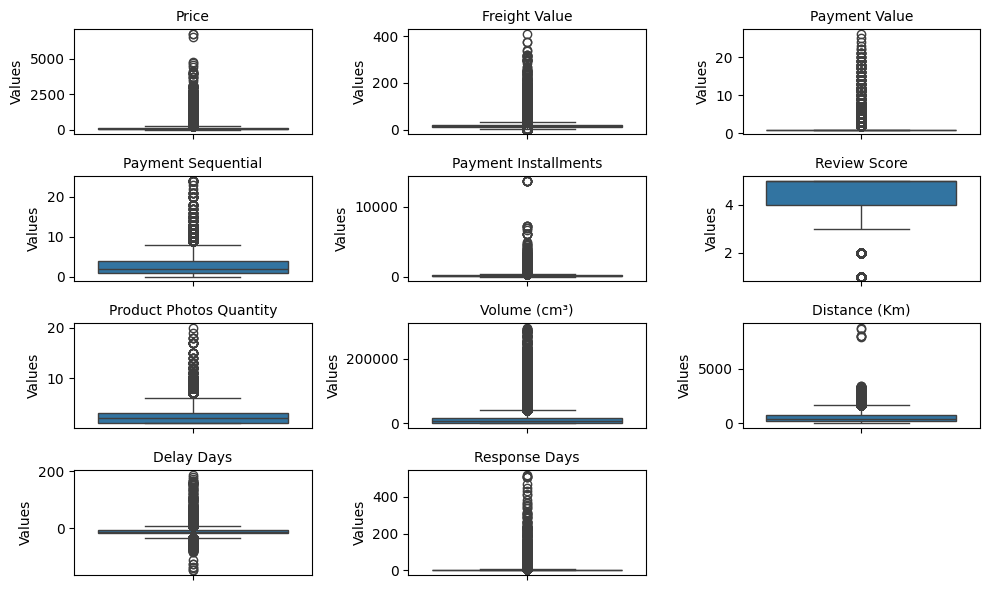

In [45]:
variables = numerical_col

titles = ["Price", "Freight Value", "Payment Value", 
          "Payment Sequential", "Payment Installments", 
          "Review Score", "Product Photos Quantity", 
          "Volume (cm³)", "Distance (Km)", "Delay Days", 'Response Days']

plt.figure(figsize=(10, 6))

for i, var in enumerate(variables):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(y=data[var])
    plt.title(titles[i], fontsize=10)
    plt.ylabel("Values")

plt.tight_layout()
plt.show()

##### Histogramms #####

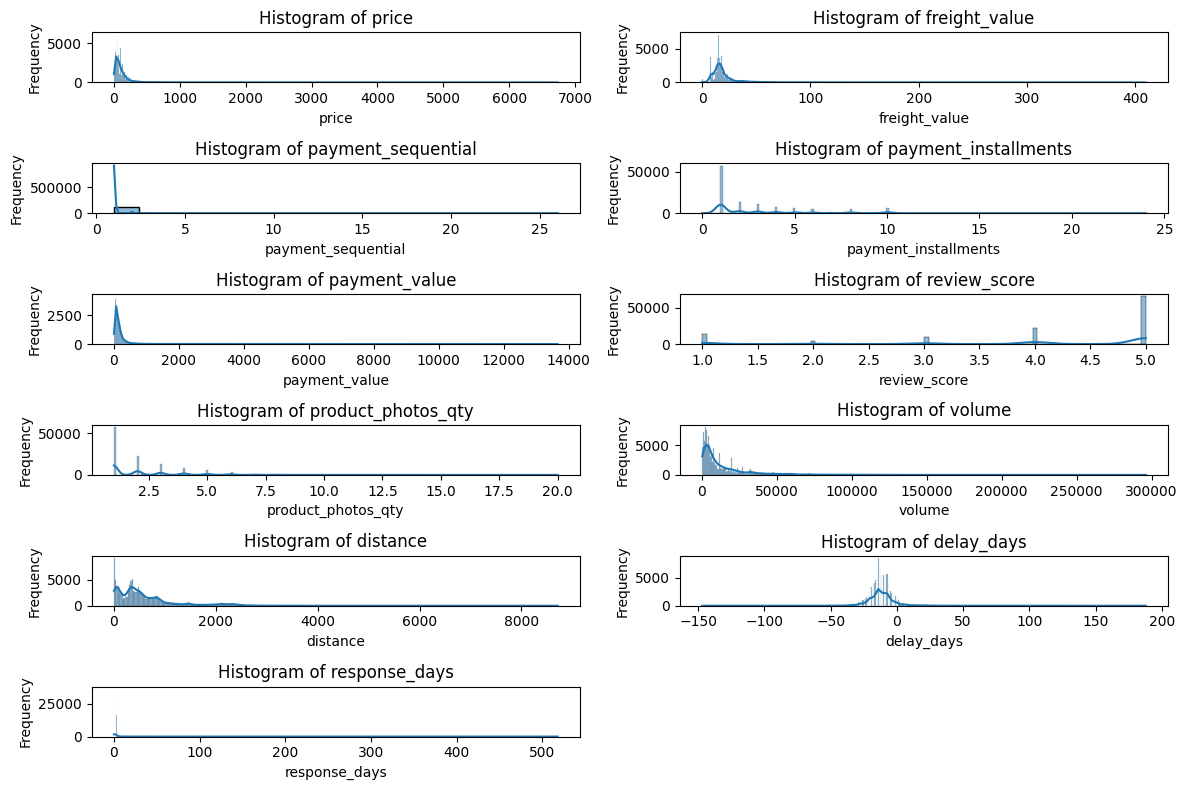

In [46]:
plt.figure(figsize=(12, 8))

for i, column in enumerate(numerical_col, 1):
    plt.subplot(6, 2, i) 
    sns.histplot(data[column].dropna(), kde=True)  
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

##### REMOVE OUTLIERS & REPEAT VISUALIZATION ####

In [47]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

data_without_outliers = data.copy()

columns_to_clean = numerical_col

for column in columns_to_clean:
    data_without_outliers = remove_outliers(data_without_outliers, column)

print(f"Original dataset shape: {data.shape}")
print(f"New dataset shape (without outliers): {data_without_outliers.shape}")

Original dataset shape: (115141, 52)
New dataset shape (without outliers): (56318, 52)


In [48]:
numerical_col = [
    'price',
    'freight_value',
    'payment_sequential',
    'payment_installments',
    'payment_value',
    'review_score',
    'product_photos_qty',
    'volume',
    'distance',
    'delay_days',
    'response_days'
]

data_without_outliers[numerical_col].describe()

,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_photos_qty,volume,distance,delay_days,response_days
count,56318.000000,56318.000000,56318.0,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000
mean,72.116407,14.751864,1.0,2.234348,97.556716,4.590344,2.036961,7548.633011,423.789931,-12.340868,1.582833
std,52.740644,4.562147,0.0,1.830684,60.668013,0.655304,1.387184,6978.638571,341.445722,6.475674,1.412260
min,0.850000,2.200000,1.0,1.000000,0.010000,3.000000,1.000000,168.000000,0.000000,-30.000000,0.000000
25%,30.910000,11.850000,1.0,1.000000,50.130000,4.000000,1.000000,2431.000000,122.457545,-16.000000,1.000000
50%,56.990000,15.100000,1.0,1.000000,81.780000,5.000000,1.000000,4784.000000,363.222449,-12.000000,1.000000
75%,99.000000,17.660000,1.0,3.000000,132.480000,5.000000,3.000000,11340.000000,612.718459,-8.000000,2.000000
max,272.010000,30.330000,1.0,8.000000,291.440000,5.000000,6.000000,31104.000000,1548.010334,5.000000,6.000000


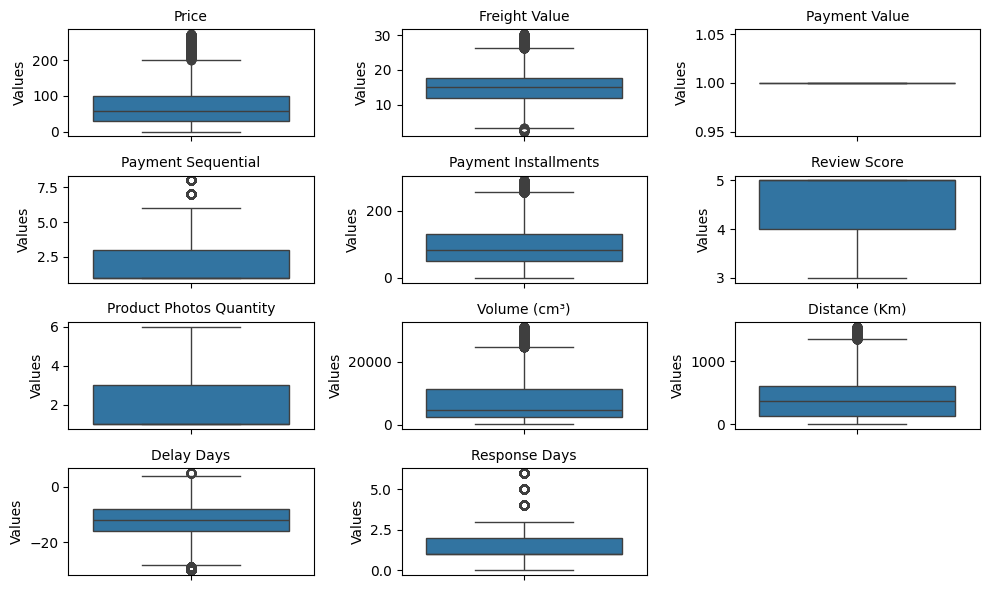

In [49]:
variables = numerical_col

titles = ["Price", "Freight Value", "Payment Value", 
          "Payment Sequential", "Payment Installments", 
          "Review Score", "Product Photos Quantity", 
          "Volume (cm³)", "Distance (Km)", "Delay Days", "Response Days"]


plt.figure(figsize=(10, 6))

for i, var in enumerate(variables):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(y=data_without_outliers[var])
    plt.title(titles[i], fontsize=10)
    plt.ylabel("Values")

plt.tight_layout()
plt.show()

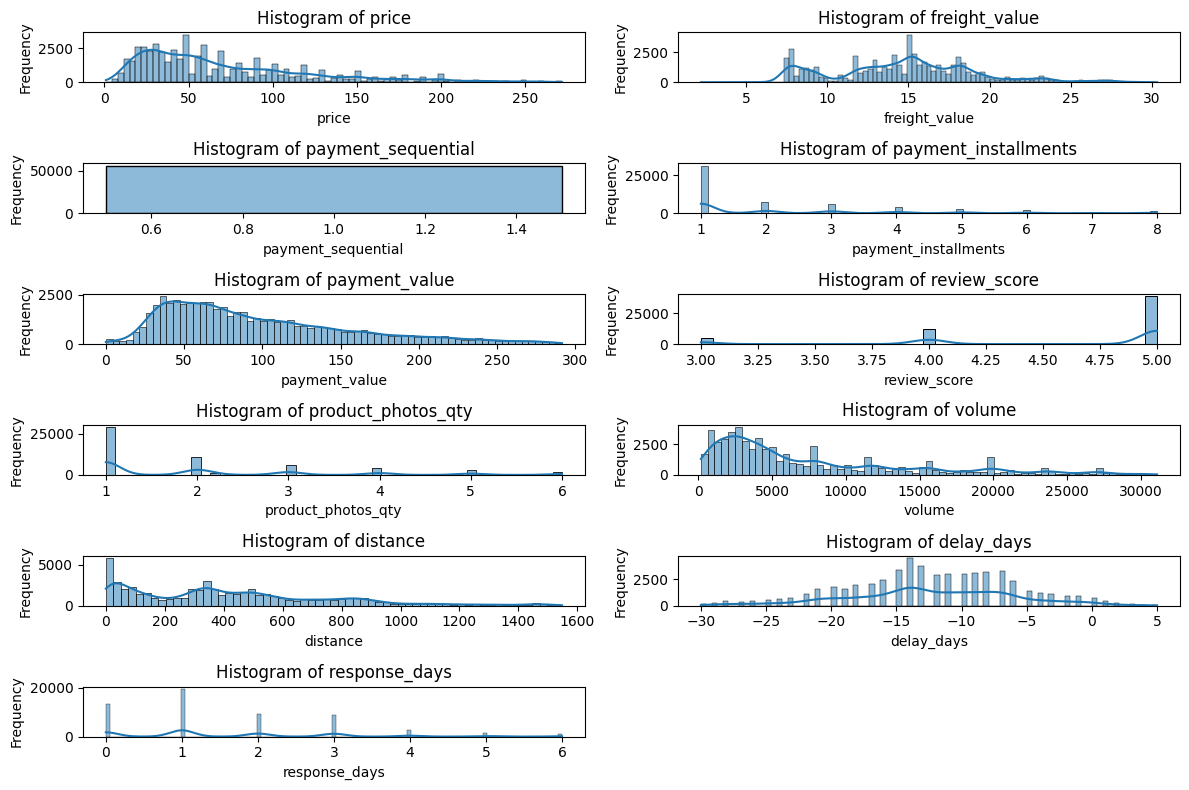

In [50]:
plt.figure(figsize=(12, 8))

for i, column in enumerate(numerical_col, 1):
    plt.subplot(6, 2, i) 
    sns.histplot(data_without_outliers[column].dropna(), kde=True) 
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Visualization of Categorical Variables ####

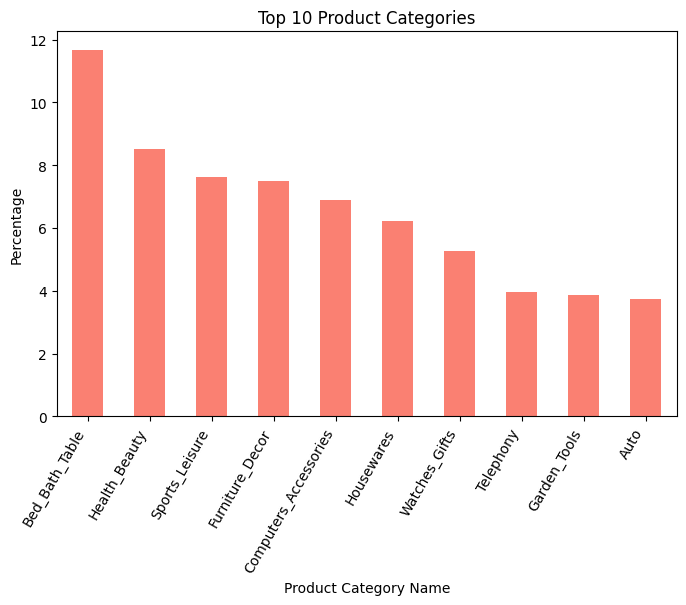

In [51]:
# Most popular Procuct Categories

product_category_percentages = data['product_category_name'].value_counts(normalize=True) * 100

top_10_percentages = product_category_percentages.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
top_10_percentages.plot(kind='bar', color='salmon')
plt.title('Top 10 Product Categories')
plt.xlabel('Product Category Name')
plt.ylabel('Percentage')
plt.xticks(rotation=60, ha='right')
plt.show()

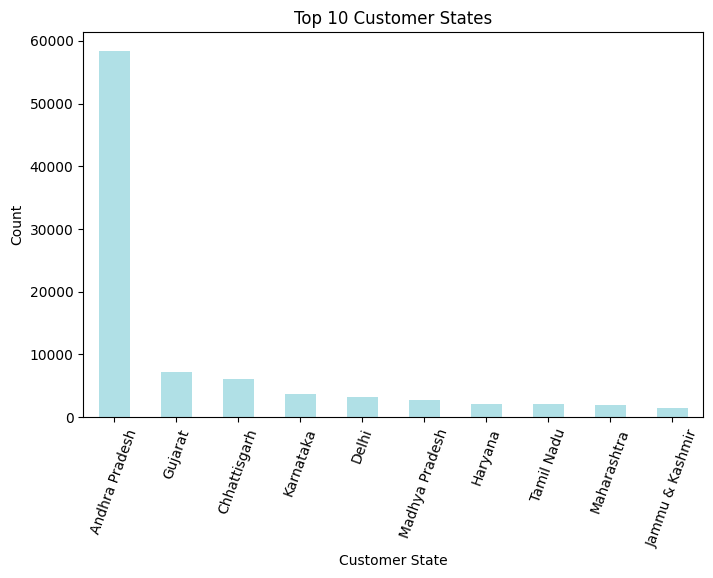

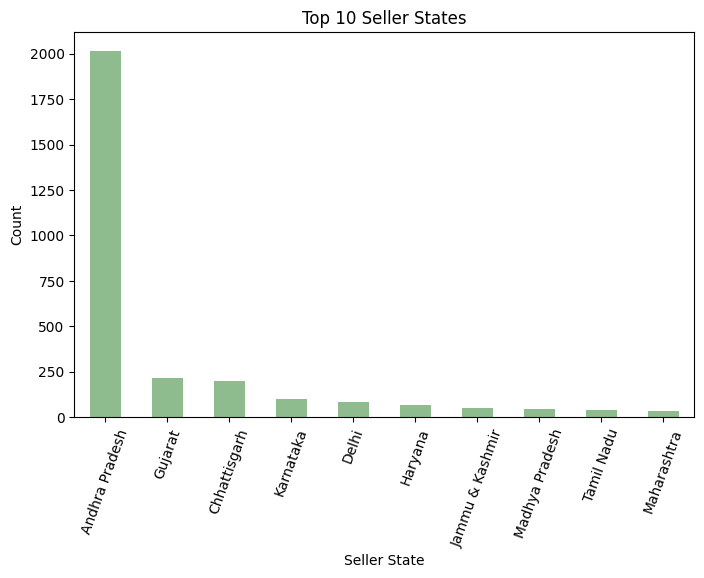

In [52]:
# States with most customers and sellers

customer_state_counts = data.groupby('customer_id')['customer_state'].first().value_counts()

seller_state_counts = data.groupby('seller_id')['seller_state'].first().value_counts()

def plot_top_states(data, color, title, xlabel, ylabel):
    top_10_states = data.nlargest(10)
    plt.figure(figsize=(8, 5))
    top_10_states.plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=70)
    plt.show()

plot_top_states(customer_state_counts, 'powderblue', 'Top 10 Customer States', 'Customer State', 'Count')
plot_top_states(seller_state_counts, 'darkseagreen', 'Top 10 Seller States', 'Seller State', 'Count')

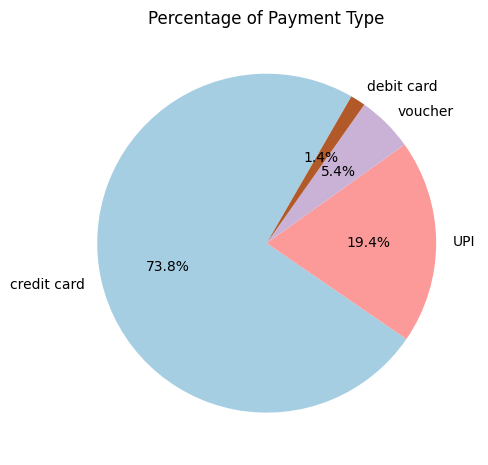

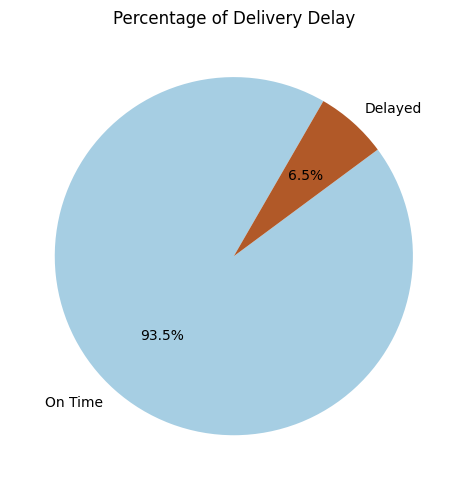

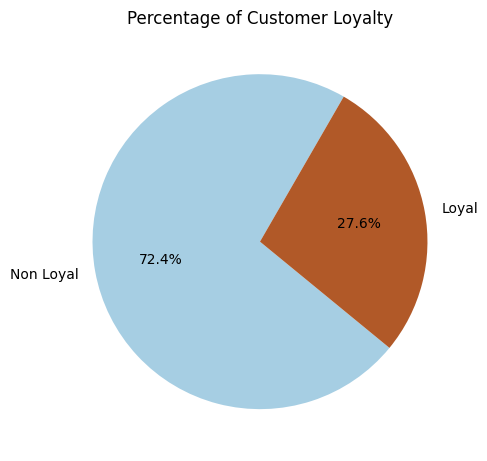

In [53]:
# Distribution of Payment Type, Delay & Loyalty

variable_labels = {
    "payment_type": "Payment Type",
    "delay": "Delivery Delay",
    "loyalty": "Customer Loyalty"
}

value_labels = {
    "payment_type": {
        "credit_card": "credit card",
        "debit_card": "debit card",
    },
    "delay": {
        0: "On Time",
        1: "Delayed"
    },
    "loyalty": {
        0: "Non Loyal",
        1: "Loyal"
    }
}

cat_variables = ["payment_type", "delay", "loyalty"]

for column in cat_variables:
    plt.figure(figsize=(5, 5))
    
    if column in value_labels:
        data[column] = data[column].map(value_labels[column]).fillna(data[column])
    
    data[column].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=60, cmap='Paired')
    plt.title(f'Percentage of {variable_labels[column]}')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

### Bivariate Analysis ###

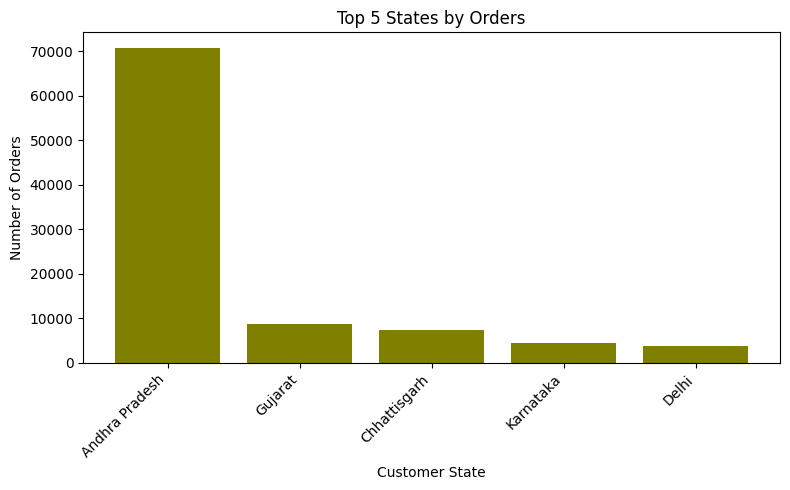

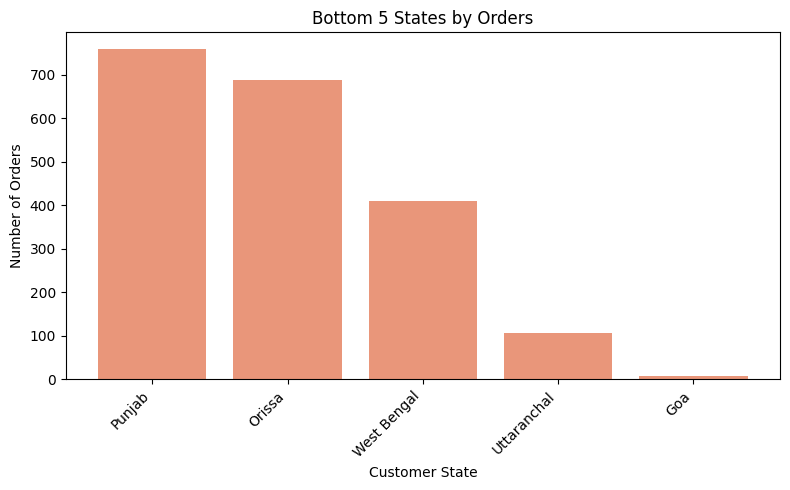

In [54]:
# Top 5 States and Bottom 5 States by Orders

order_counts_per_state = data.groupby('customer_state')['order_id'].count()

sorted_states = order_counts_per_state.sort_values()

top_5_states = sorted_states.tail(5)
bottom_5_states = sorted_states.head(5)

top_5_states = top_5_states.sort_values(ascending=False)
bottom_5_states = bottom_5_states.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(top_5_states.index, top_5_states.values, color='olive')
plt.title('Top 5 States by Orders')
plt.xlabel('Customer State')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(bottom_5_states.index, bottom_5_states.values, color='darksalmon')
plt.title('Bottom 5 States by Orders')
plt.xlabel('Customer State')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

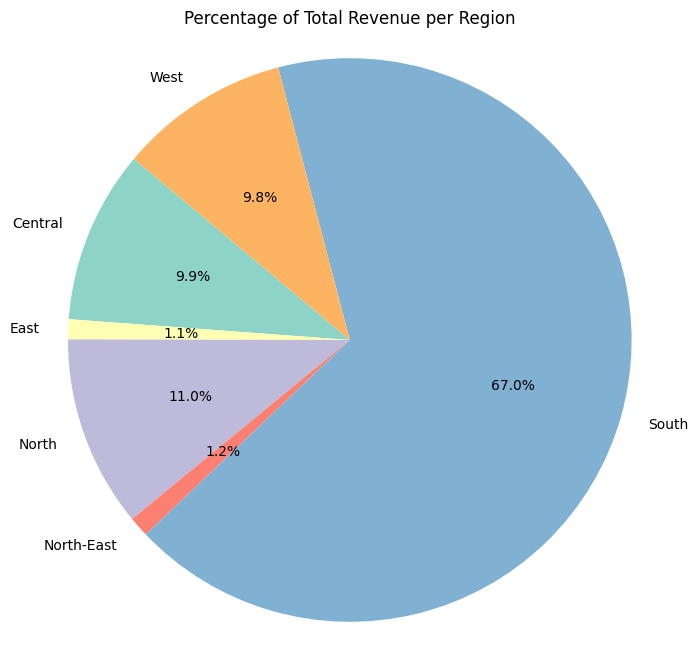

In [55]:
# What's the average revenue per Region?

revenue_per_region = data.groupby('customer_region')['price'].sum()

total_revenue = revenue_per_region.sum()

percentage_revenue_per_region = (revenue_per_region / total_revenue) * 100

plt.figure(figsize=(8, 8))
colors = plt.cm.Set3.colors 
plt.pie(percentage_revenue_per_region, labels=percentage_revenue_per_region.index, 
        autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Total Revenue per Region')
plt.ylabel('')
plt.axis('equal')
plt.show()

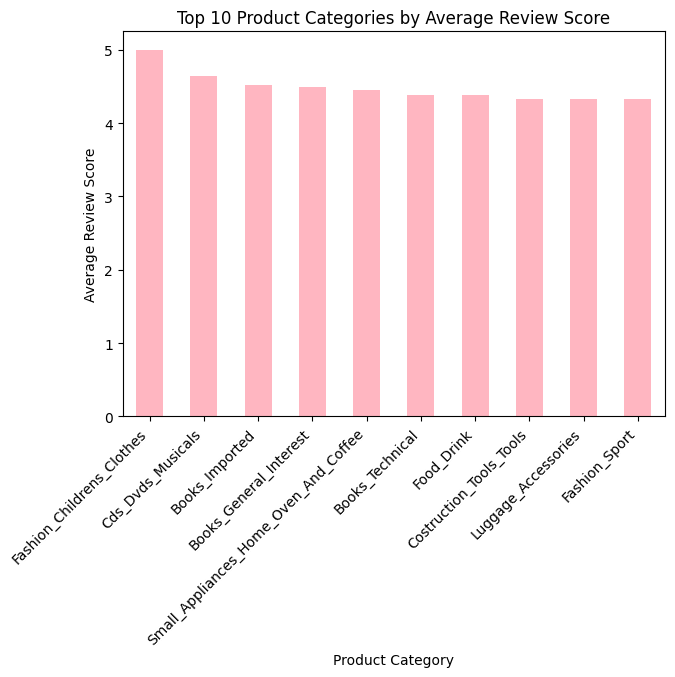

In [56]:
# Top 10 Categories with the Highest Review Score

avg_review_by_category = data.groupby('product_category_name')['review_score'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(7, 5))
avg_review_by_category.plot(kind='bar', color='lightpink')
plt.title('Top 10 Product Categories by Average Review Score')
plt.xlabel('Product Category')
plt.ylabel('Average Review Score')
plt.xticks(rotation=45, ha='right')
plt.show()

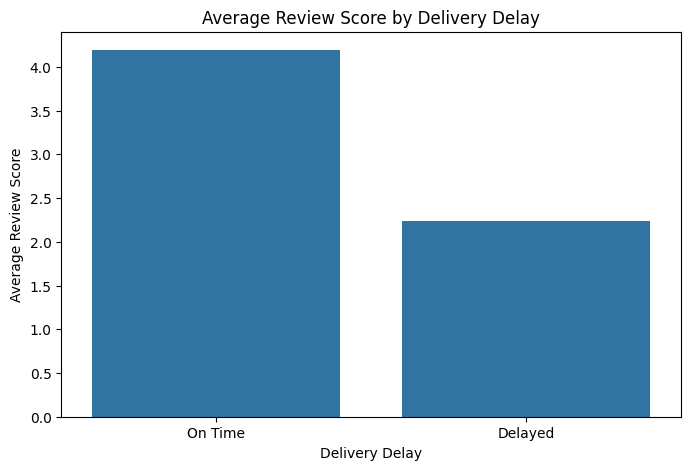

In [57]:
# Does the delay impacts the review_score?

plt.figure(figsize=(8, 5))
sns.barplot(x='delay', y='review_score', data=data, errorbar=None)
plt.title('Average Review Score by Delivery Delay')
plt.xlabel('Delivery Delay')
plt.ylabel('Average Review Score')
plt.show()

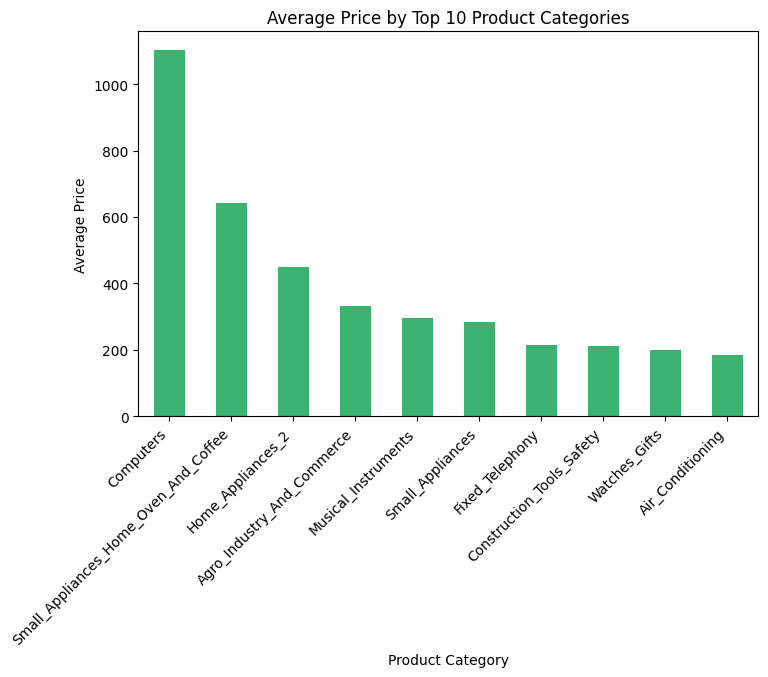

In [58]:
# Top 10 most expensive categories

avg_price_by_category = data.groupby('product_category_name')['price'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 5))
avg_price_by_category.plot(kind='bar', color='mediumseagreen')
plt.title('Average Price by Top 10 Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Correlation Analysis ####

#### Scatter Plot ####

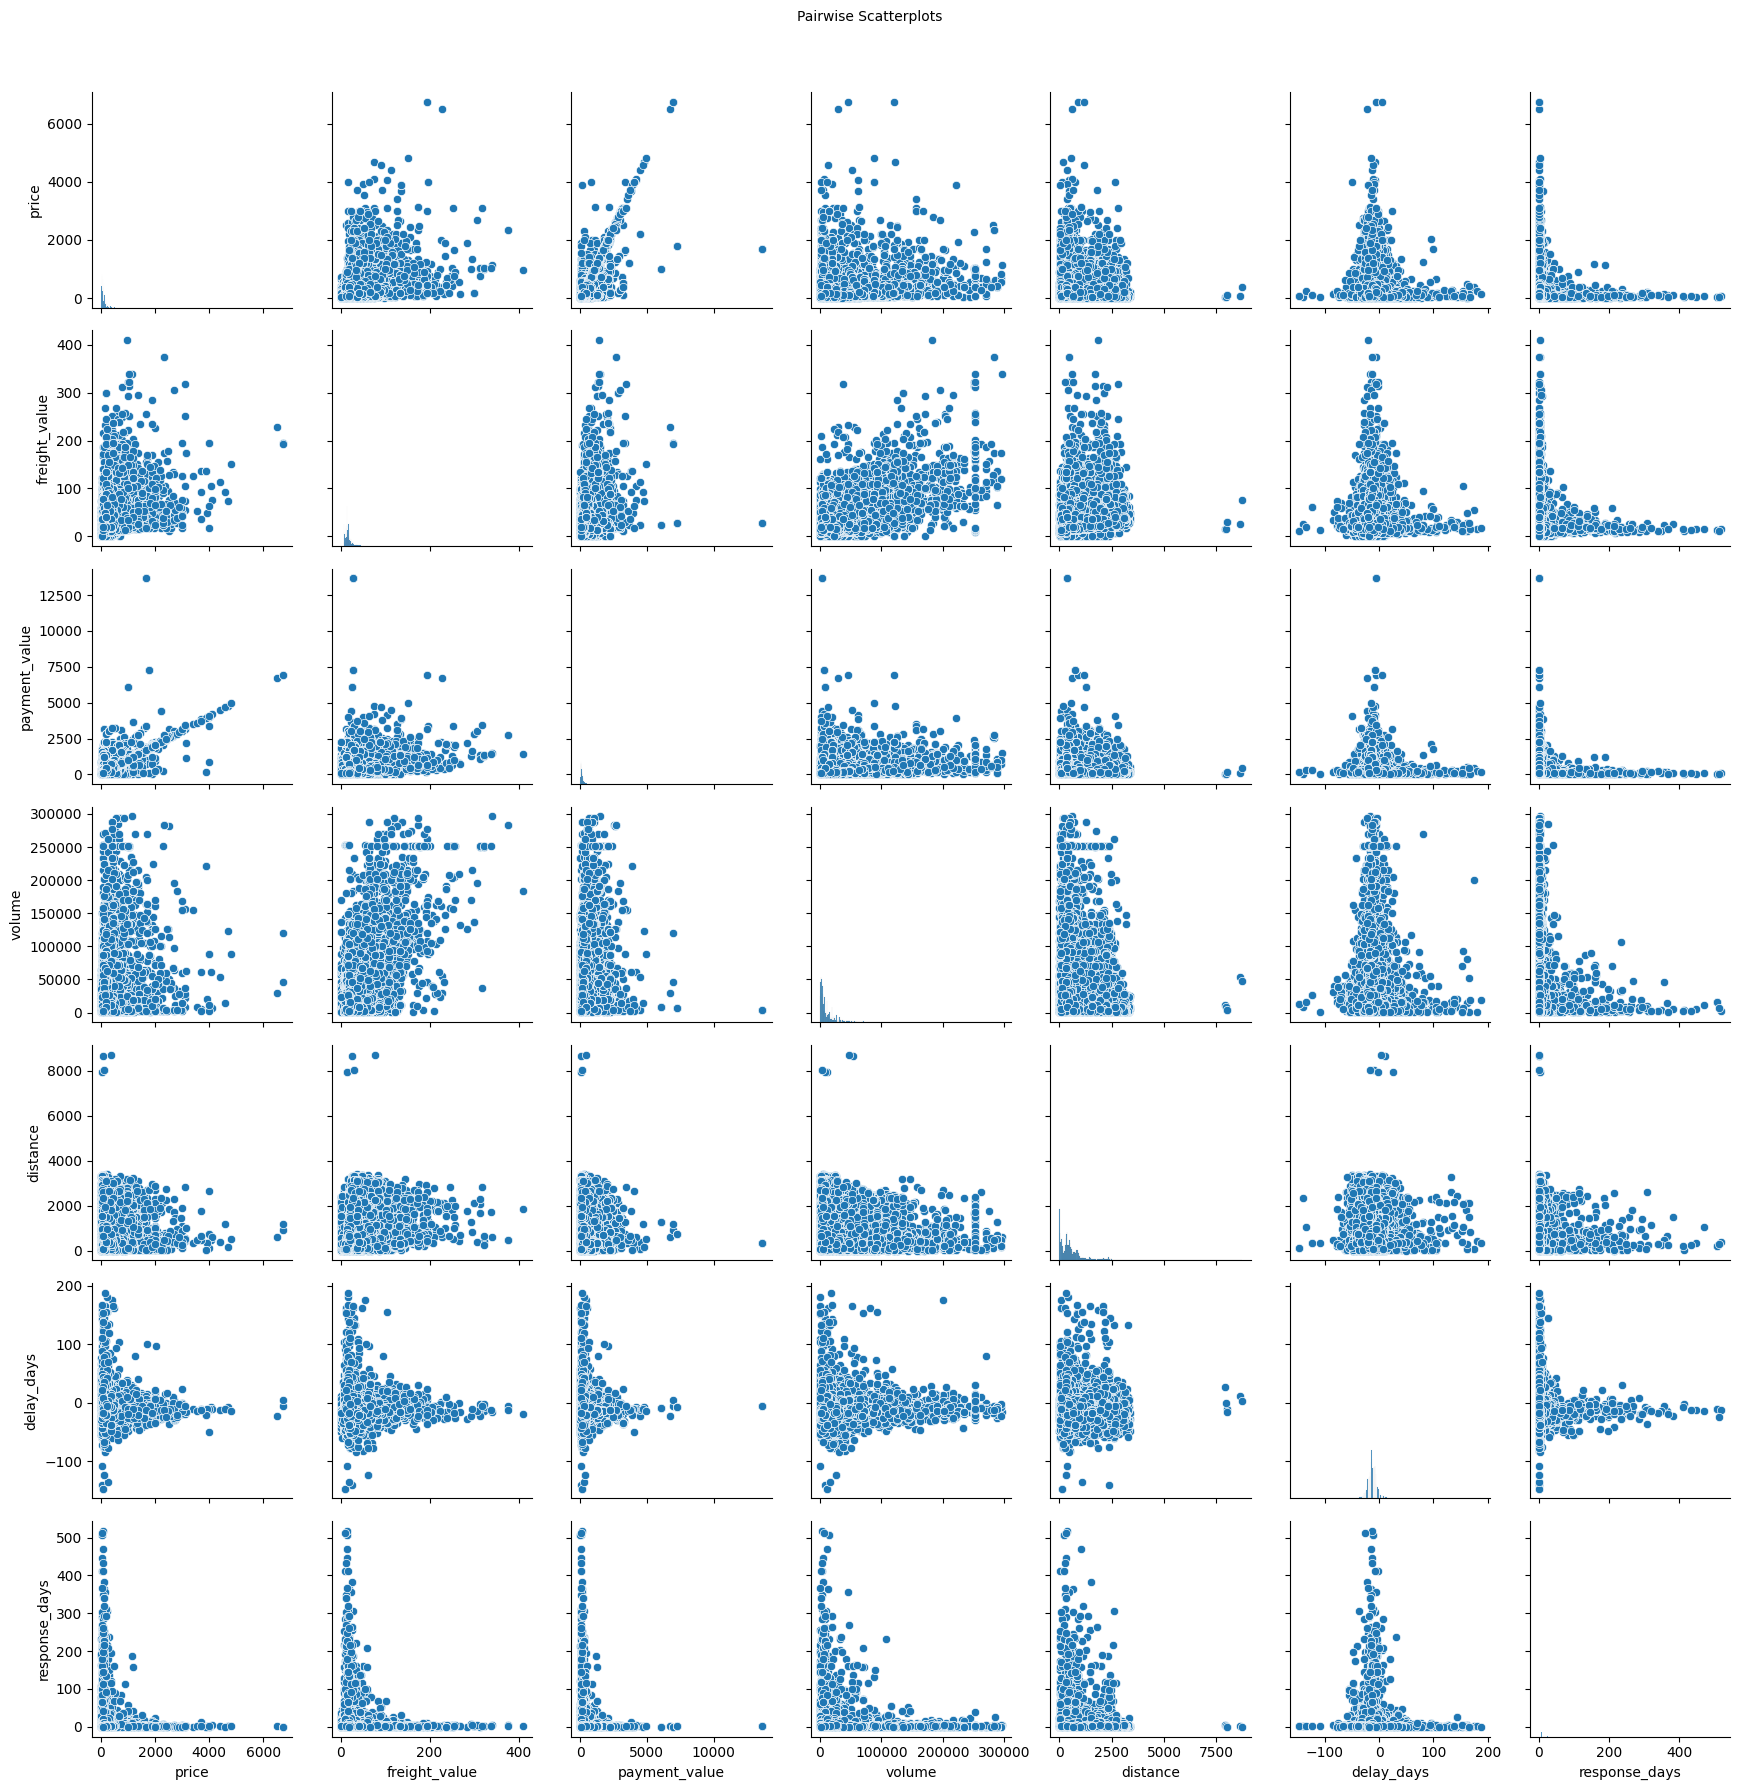

In [59]:
num_var = [
    'price',
    'freight_value',
    'payment_value',
    'volume',
    'distance',
    'delay_days',
    'response_days'
]

filtered_data = data[num_var]

sns.pairplot(filtered_data)
plt.suptitle('Pairwise Scatterplots', y=1.02, size=10)
plt.tight_layout()
plt.show()

#### Spearman's Test ####

In [60]:
# Does the freight value depends from the volume, weight and distance of the order?

spearman_corr1 = data['freight_value'].corr(data['distance'], method='spearman')
spearman_corr2 = data['freight_value'].corr(data['volume'], method='spearman')
spearman_corr3 = data['freight_value'].corr(data['product_weight_g'], method='spearman')

print(f"freight_value and distance : {spearman_corr1}")
print(f"freight_value and volume   : {spearman_corr2}")
print(f"reight_value and weight    : {spearman_corr3}")

freight_value and distance : 0.6255529842400558
freight_value and volume   : 0.3632425916124718
reight_value and weight    : 0.43998937968137375


In [61]:
# What is the correlation between payment_value, price, and freight_value ?

spearman_corr4 = data['payment_value'].corr(data['price'], method='spearman')
spearman_corr5 = data['payment_value'].corr(data['freight_value'], method='spearman')

print(f"payment_value and price         : {spearman_corr4}")
print(f"payment_value and freight_value : {spearman_corr5}")

payment_value and price         : 0.7893824070703025
payment_value and freight_value : 0.4227464825279251


In [62]:
# Is there indeed a relationship between price and volume ?

spearman_corr6 = data['price'].corr(data['volume'], method='spearman')

print(f"price and volume: {spearman_corr6}")

price and volume: 0.38706934549479843


In [63]:
# Distance, Volume and Weight impact Delay_Days?

spearman_corr7 = data['delay_days'].corr(data['distance'], method='spearman')
spearman_corr8 = data['delay_days'].corr(data['volume'], method='spearman')
spearman_corr9 = data['delay_days'].corr(data['product_weight_g'], method='spearman')

print(f"delay_days and distance : {spearman_corr7}")
print(f"delay_days and volume   : {spearman_corr8}")
print(f"delay_days and weight   : {spearman_corr9}")

delay_days and distance : -0.18185167812184483
delay_days and volume   : -0.008387098604846226
delay_days and weight   : -0.007087016253852067


In [64]:
# Does the delay influence the review score?

spearman_corr10 = data['review_score'].corr(data['delay_days'], method='spearman')

print(f"review_score and delay_days : {spearman_corr9}")


review_score and delay_days : -0.007087016253852067


In [65]:
# Payment Installments depends on payment value?

spearman_corr11 = data['payment_installments'].corr(data['payment_value'], method='spearman')

print(f"payment_installments and payment_value : {spearman_corr11}")


payment_installments and payment_value : 0.3954548094740742


### Customer Analysis ###

##### 1. Explore customers purchasing behavior 

##### a. Which are the most popular products categories bewteen loyal and non loyal customers?

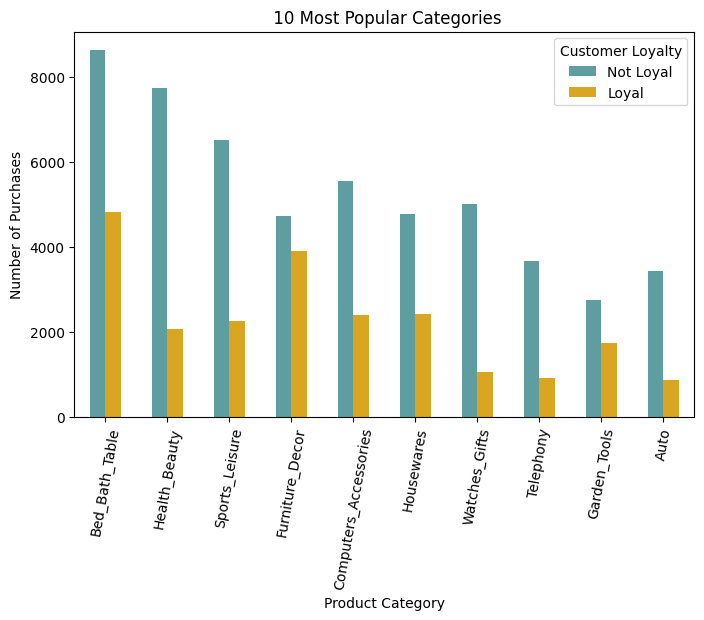

In [66]:
category_counts = data.groupby(['loyalty', 'product_category_name']).size().unstack(fill_value=0)

category_counts = category_counts.T

top_categories = category_counts.sum(axis=1).nlargest(10).index
top_category_counts = category_counts.loc[top_categories]

top_category_counts = top_category_counts[['Non Loyal', 'Loyal']]

colors= ['cadetblue', 'goldenrod']
top_category_counts.plot(kind='bar', figsize=(8, 5), color=colors)
plt.title(' 10 Most Popular Categories')
plt.xlabel('Product Category')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=80)
plt.legend(title='Customer Loyalty', labels=['Not Loyal', 'Loyal'])
plt.show()


In [67]:
print(top_category_counts)

loyalty                Non Loyal  Loyal
product_category_name                  
Bed_Bath_Table              8637   4806
Health_Beauty               7729   2057
Sports_Leisure              6523   2250
Furniture_Decor             4723   3897
Computers_Accessories       5538   2400
Housewares                  4769   2409
Watches_Gifts               5013   1038
Telephony                   3669    905
Garden_Tools                2743   1725
Auto                        3421    870


##### b. Which is the preferred payment type between loyal and non loyal customers

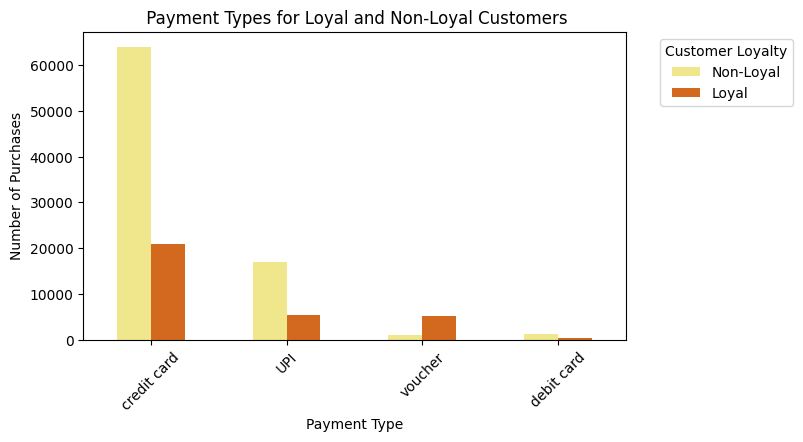

In [68]:
# Payment types 

loyal_payment_counts = data.groupby(['loyalty', 'payment_type']).size().unstack(fill_value=0)
loyal_payment_counts = loyal_payment_counts.T

loyal_payment_counts['Total'] = loyal_payment_counts.sum(axis=1)
loyal_payment_counts = loyal_payment_counts.sort_values(by='Total', ascending=False)
loyal_payment_counts = loyal_payment_counts.drop(columns=['Total'])
loyal_payment_counts = loyal_payment_counts[['Non Loyal', 'Loyal']]

colors = ['khaki', 'chocolate']
loyal_payment_counts.plot(kind='bar', figsize=(7, 4), color=colors)
plt.title(' Payment Types for Loyal and Non-Loyal Customers')
plt.xlabel('Payment Type')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.legend(title='Customer Loyalty', bbox_to_anchor=(1.05, 1), loc='upper left', labels=['Non-Loyal', 'Loyal'])
plt.show()


In [69]:
print(loyal_payment_counts)

loyalty       Non Loyal  Loyal
payment_type                  
credit card       64039  20890
UPI               16957   5437
voucher            1007   5154
debit card         1356    301


##### c. Which hour the most orders take place?

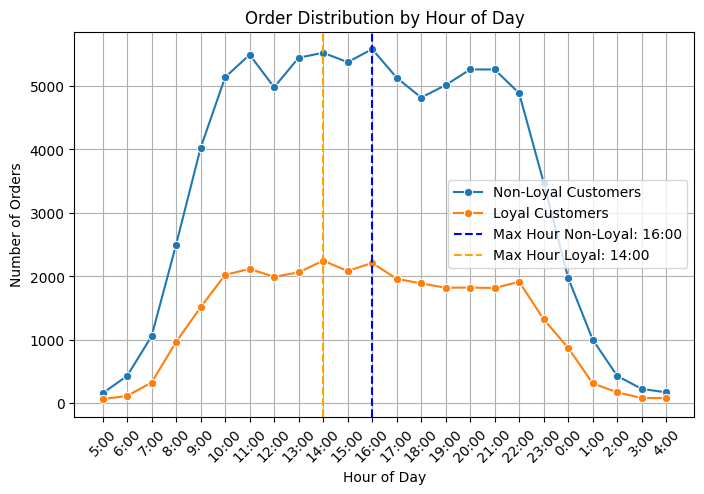

 For non-loyal customers is 16:00 with 5582 orders.
 For loyal customers is 14:00 with 2247 orders.


In [70]:
loyal_customers = data[data['loyalty'] == 'Loyal']
non_loyal_customers = data[data['loyalty'] == 'Non Loyal']

order_distribution_nonloyal = non_loyal_customers['order_hour'].value_counts().sort_index()
order_distribution_loyal = loyal_customers['order_hour'].value_counts().sort_index()

max_hour_non_loyal = order_distribution_nonloyal.idxmax()
max_orders_non_loyal = order_distribution_nonloyal.max()
max_hour_loyal = order_distribution_loyal.idxmax()
max_orders_loyal = order_distribution_loyal.max()


hours = list(range(5, 24)) + list(range(0, 5)) 
order_distribution_nonloyal = order_distribution_nonloyal.reindex(hours, fill_value=0)
order_distribution_loyal = order_distribution_loyal.reindex(hours, fill_value=0)


hour_labels = [f'{h}:00' for h in hours]

plt.figure(figsize=(8, 5))
sns.lineplot(x=hour_labels, y=order_distribution_nonloyal.values, label='Non-Loyal Customers', marker='o')
sns.lineplot(x=hour_labels, y=order_distribution_loyal.values, label='Loyal Customers', marker='o')


plt.axvline(x=hour_labels[hours.index(max_hour_non_loyal)], color='blue', linestyle='--', label=f'Max Hour Non-Loyal: {max_hour_non_loyal}:00')
plt.axvline(x=hour_labels[hours.index(max_hour_loyal)], color='orange', linestyle='--', label=f'Max Hour Loyal: {max_hour_loyal}:00')


plt.xticks(rotation=45)
plt.title('Order Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

print(f" For non-loyal customers is {max_hour_non_loyal}:00 with {max_orders_non_loyal} orders.")
print(f" For loyal customers is {max_hour_loyal}:00 with {max_orders_loyal} orders.")


##### d. In which city located the more loyal customers ?

The customer_city with the most loyal customers is Akkarampalle with 5322 loyal customers.


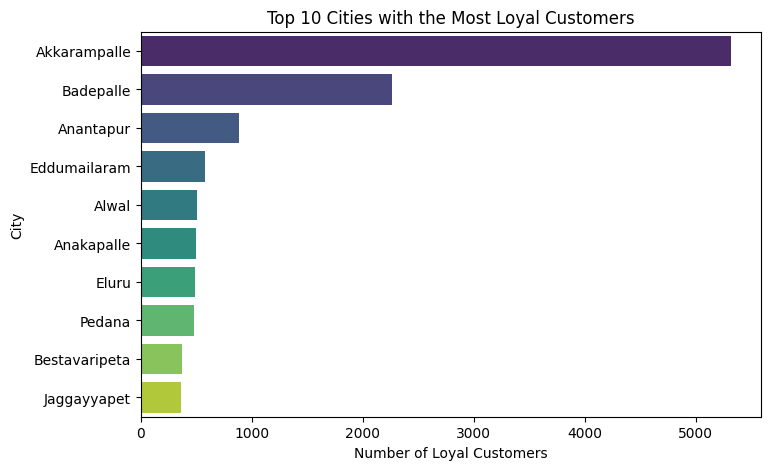

In [71]:
loyal_customers_by_city = loyal_customers.groupby('customer_city').size().reset_index(name='loyal_customer_count')

top_10_loyal_customers_city = loyal_customers_by_city.sort_values(by='loyal_customer_count', ascending=False).head(10)

most_loyal_customers_city = top_10_loyal_customers_city.iloc[0]

print(f"The customer_city with the most loyal customers is {most_loyal_customers_city['customer_city']} with {most_loyal_customers_city['loyal_customer_count']} loyal customers.")

plt.figure(figsize=(8, 5))
sns.barplot(x='loyal_customer_count', y='customer_city', data=top_10_loyal_customers_city, palette='viridis', hue='customer_city', legend='auto')

plt.title('Top 10 Cities with the Most Loyal Customers')
plt.xlabel('Number of Loyal Customers')
plt.ylabel('City')
plt.show()

In [72]:
data['loyalty'] = data['loyalty'].map({'Loyal': 1, 'Non Loyal': 0})
data['delay'] = data['delay'].map({'Delayed': 1, 'On Time': 0})

##### e. How has customer loyalty evolved over time?

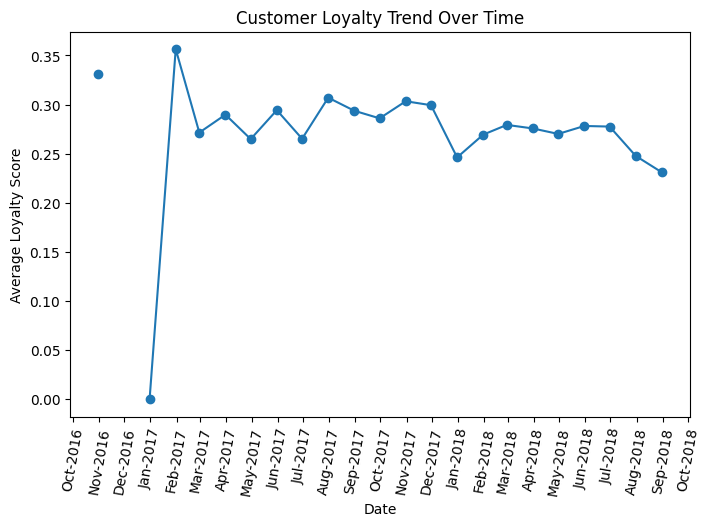

In [73]:
data.set_index('order_purchase_timestamp', inplace=True)
loyalty_trend = data['loyalty'].resample('ME').mean()

plt.figure(figsize=(8, 5))
plt.plot(loyalty_trend, marker='o', linestyle='-')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=80) 
plt.title('Customer Loyalty Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Loyalty Score')
plt.show()

data.reset_index(inplace=True)

columns = ['order_id', 'order_purchase_timestamp'] + [col for col in data.columns if col not in ['order_id', 'order_purchase_timestamp']]
data = data[columns]


##### 2. What is the common characteristics of loyal customers? Can we predict if a customer will be loyal?

#### Random Forest Algorithm ####

=== Imbalanced Data Model ===
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     25008
           1       0.92      0.78      0.84      9535

    accuracy                           0.92     34543
   macro avg       0.92      0.88      0.89     34543
weighted avg       0.92      0.92      0.92     34543

Accuracy: 0.9193
Precision: 0.9166
Recall: 0.7787
ROC-AUC: 0.9335
Confusion Matrix:
[[24332   676]
 [ 2110  7425]]
Cross-Validated ROC-AUC scores: [0.92354376 0.92111958 0.92497102 0.91933207 0.92078603]
Mean Cross-Validated ROC-AUC: 0.9220
Feature Importances:
payment_value           0.286098
freight_value           0.227487
delay_days              0.111669
payment_sequential      0.097093
order_hour              0.086036
response_days           0.057544
payment_installments    0.047578
review_score            0.047174
product_photos_qty      0.039319
dtype: float64


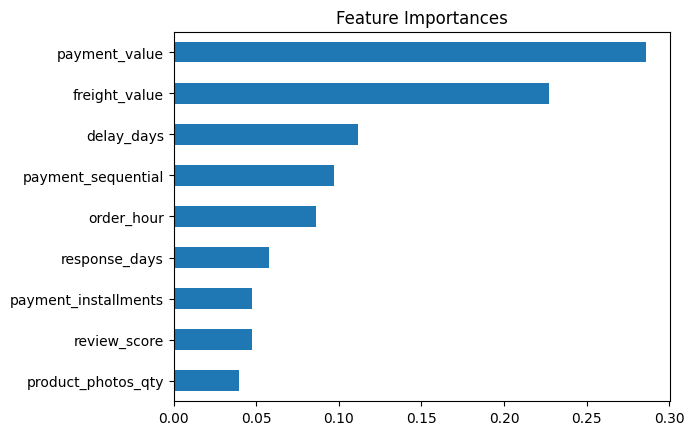

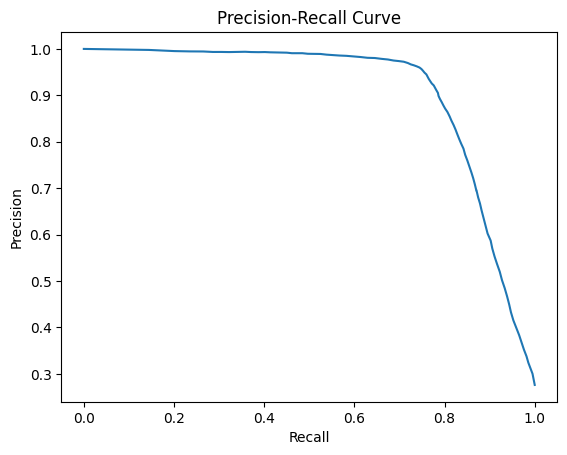


=== SMOTE Model ===
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     25008
           1       0.85      0.80      0.82      9535

    accuracy                           0.90     34543
   macro avg       0.89      0.87      0.88     34543
weighted avg       0.90      0.90      0.90     34543

Accuracy: 0.9040
Precision: 0.8466
Recall: 0.7966
ROC-AUC: 0.9261
Confusion Matrix:
[[23632  1376]
 [ 1939  7596]]
Cross-Validated ROC-AUC scores: [0.97243274 0.9710994  0.97132427 0.97081139 0.97157909]
Mean Cross-Validated ROC-AUC: 0.9714
Feature Importances:
payment_value           0.269117
freight_value           0.184965
payment_sequential      0.098980
delay_days              0.096594
product_photos_qty      0.095437
payment_installments    0.079516
order_hour              0.076321
review_score            0.052396
response_days           0.046675
dtype: float64


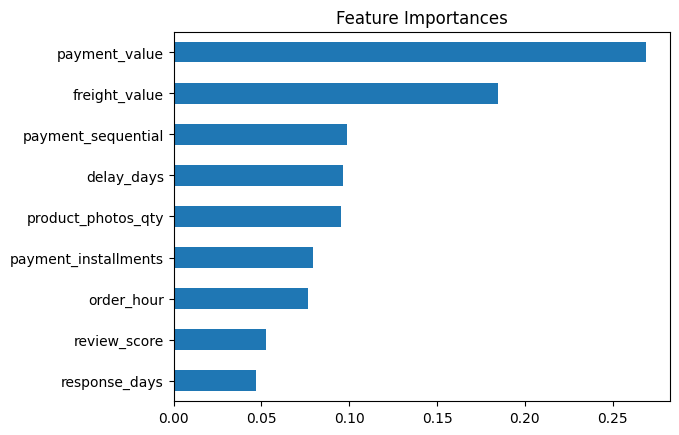

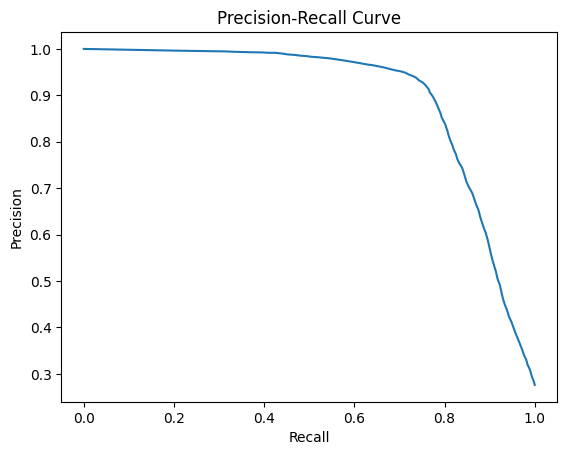


=== Undersampling Model ===
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     25008
           1       0.72      0.85      0.78      9535

    accuracy                           0.87     34543
   macro avg       0.83      0.86      0.85     34543
weighted avg       0.88      0.87      0.87     34543

Accuracy: 0.8700
Precision: 0.7245
Recall: 0.8537
ROC-AUC: 0.9268
Confusion Matrix:
[[21913  3095]
 [ 1395  8140]]
Cross-Validated ROC-AUC scores: [0.91303313 0.91297544 0.91365506 0.91136284 0.91113739]
Mean Cross-Validated ROC-AUC: 0.9124
Feature Importances:
payment_value           0.289313
freight_value           0.221803
delay_days              0.115668
order_hour              0.091612
payment_sequential      0.078567
response_days           0.059680
review_score            0.050526
payment_installments    0.050288
product_photos_qty      0.042543
dtype: float64


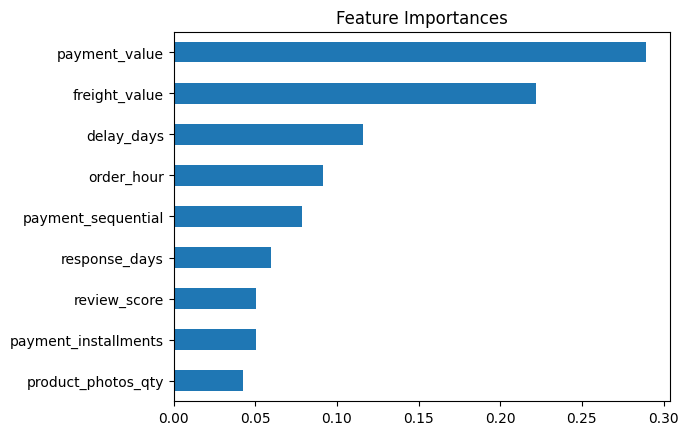

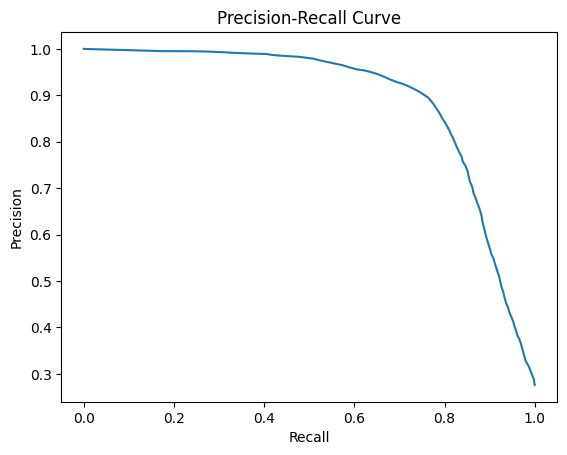

In [74]:
features = [
    'payment_sequential', 'payment_value', 'payment_installments',
    'response_days', 'order_hour', 'freight_value', 'delay_days', 'product_photos_qty', 'review_score',
]
X = data[features]
y = data['loyalty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Model 1: Imbalanced Data (No Resampling)
model_imbalanced = RandomForestClassifier(random_state=42)
model_imbalanced.fit(X_train, y_train)

# Model 2: SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_smote, y_smote)

# Model 3: Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)
model_under = RandomForestClassifier(random_state=42)
model_under.fit(X_under, y_under)

def evaluate_model(model, X_test, y_test, X_train, y_train, features):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Classification Report")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cross_val_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f"Cross-Validated ROC-AUC scores: {cross_val_auc}")
    print(f"Mean Cross-Validated ROC-AUC: {cross_val_auc.mean():.4f}")

    importance_scores = pd.Series(model.feature_importances_, index=features)
    sorted_importance_scores = importance_scores.sort_values(ascending=False)
    print("Feature Importances:")
    print(sorted_importance_scores)

    feature_importances = pd.Series(model.feature_importances_, index=features)
    feature_importances.sort_values().plot(kind='barh')
    plt.title('Feature Importances')
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    
print("=== Imbalanced Data Model ===")
evaluate_model(model_imbalanced, X_test, y_test, X_train, y_train, features)

print("\n=== SMOTE Model ===")
evaluate_model(model_smote, X_test, y_test, X_smote, y_smote, features)

print("\n=== Undersampling Model ===")
evaluate_model(model_under, X_test, y_test, X_under, y_under, features)



### High value customers analysis 

#### Importance of High-value customers ####

In [75]:
# Calculate clv (customers lifetime value) for each customer

customer_data = data.groupby('customer_id').agg({
    'customer_city': 'first',
    'customer_state': 'first',
    'customer_lat' : 'first',
    'customer_lng' : 'first',
    'price': 'sum',
    'freight_value': 'mean',
    'payment_sequential': 'first',
    'payment_type': lambda x: x.mode()[0], 
    'payment_installments': 'mean',
    'order_id': 'count', 
    'payment_value': 'mean',
    'review_score': 'mean',  
    'product_category_name': lambda x: x.mode()[0],
    'customer_region': 'first',
    'year': lambda x: x.mode()[0],
    'loyalty': 'max',
    'month': lambda x: x.mode()[0],
    'order_hour': lambda x: x.mode()[0],
    'delay': 'mean'

}).reset_index()


customer_data.rename(columns={
    'order_id': 'num_orders',
    'price' : 'revenue'

}, inplace=True)


years = 2
customer_data['avg_purchase_value'] = customer_data['revenue'] / customer_data['num_orders']

customer_data['clv'] = customer_data['avg_purchase_value'] * customer_data['num_orders'] * years


In [76]:
# Create new variable cust_value based on mean clv

mean_clv = customer_data['clv'].mean()
customer_data['high_value_cust'] = (customer_data['clv'] > mean_clv).astype(int)

customer_data.head()

,customer_id,customer_city,customer_state,customer_lat,customer_lng,revenue,freight_value,payment_sequential,payment_type,payment_installments,...,product_category_name,customer_region,year,loyalty,month,order_hour,delay,avg_purchase_value,clv,high_value_cust
0,00012a2ce6f8dcda20d059ce98491703,Nagari,Andhra Pradesh,-23.499689,-46.766901,89.80,24.94,1.0,credit card,8.0,...,Toys,South,2017,0,11,16,0.0,89.80,179.60,0
1,000161a058600d5901f007fab4c27140,Nagrota Bagwan,Himachal Pradesh,-20.470582,-45.108716,54.90,12.51,1.0,credit card,5.0,...,Health_Beauty,North,2017,0,7,9,0.0,54.90,109.80,0
2,0001fd6190edaaf884bcaf3d49edf079,Tirupati (NMA),Andhra Pradesh,-18.716793,-40.397969,179.99,15.43,1.0,credit card,10.0,...,Baby,South,2017,0,3,11,0.0,179.99,359.98,1
3,0002414f95344307404f0ace7a26f1d5,Lakheri,Rajasthan,-21.770599,-43.355230,149.90,29.45,1.0,UPI,1.0,...,Cool_Stuff,North,2017,0,9,13,0.0,149.90,299.80,1
4,000379cdec625522490c315e70c7a9fb,Akkarampalle,Andhra Pradesh,-23.741140,-46.690509,93.00,14.01,1.0,UPI,1.0,...,Bed_Bath_Table,South,2018,0,4,13,0.0,93.00,186.00,0


Percentage of High-Value Customers: 28.32%


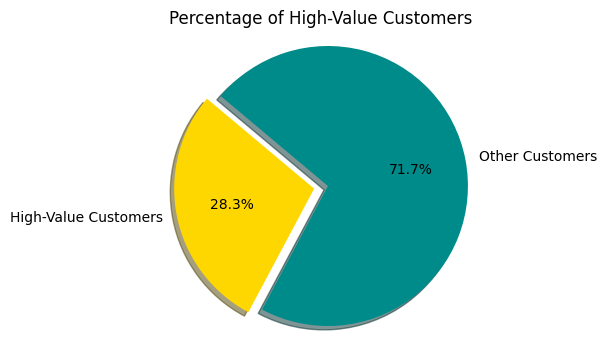

In [77]:
# Calculation and visualization the participation of high-value cust in total population 

total_customers = customer_data.shape[0]
high_value_count = customer_data['high_value_cust'].sum()
percentage_high_value_customers = (high_value_count / total_customers) * 100

print(f"Percentage of High-Value Customers: {percentage_high_value_customers:.2f}%")

labels = ['High-Value Customers', 'Other Customers']
sizes = [high_value_count, total_customers - high_value_count]
colors = ['gold', 'darkcyan']
explode = (0.1, 0) 

plt.figure(figsize=(6, 4))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Percentage of High-Value Customers')
plt.axis('equal')
plt.show()

Participation Percentage of High-Value Customers in Revenue: 66.63%


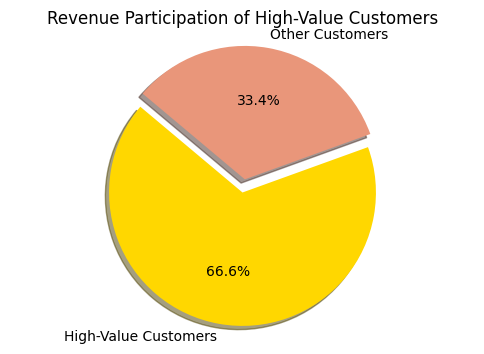

In [78]:
# Calculation and visualization of high-value customers in revenue

customer_revenue = customer_data.groupby('customer_id')['revenue'].sum()
total_cust_revenue = customer_revenue.sum()

high_value_customer_ids = customer_data[customer_data['high_value_cust'] == 1]['customer_id']
revenue_high_value_customers = customer_revenue[customer_revenue.index.isin(high_value_customer_ids)].sum()
revenue_other_customers = total_cust_revenue - revenue_high_value_customers
participation_percentage_high_value = (revenue_high_value_customers / total_cust_revenue) * 100

print(f"Participation Percentage of High-Value Customers in Revenue: {participation_percentage_high_value:.2f}%")

labels = ['High-Value Customers', 'Other Customers']
sizes = [revenue_high_value_customers, revenue_other_customers]
colors = ['gold', 'darksalmon']
explode = (0.1, 0)  

plt.figure(figsize=(6, 4))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Revenue Participation of High-Value Customers')
plt.axis('equal')
plt.show()

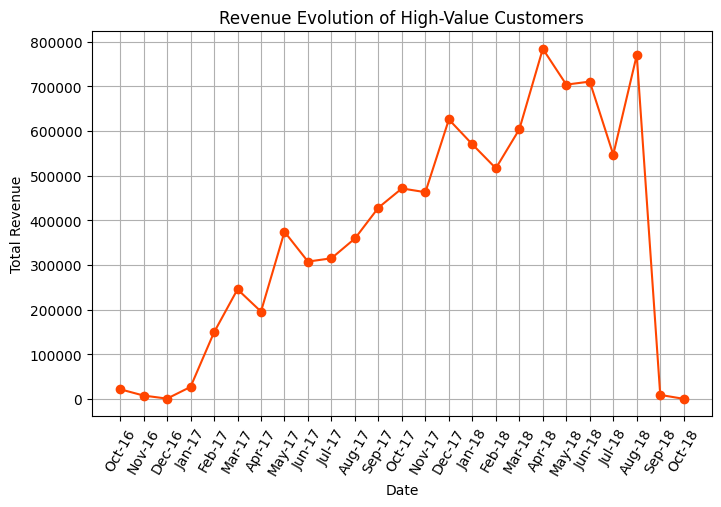

In [79]:
# Total Revenue over time 

high_value_customers = customer_data[customer_data['high_value_cust'] == 1]

revenue_evolution = high_value_customers.groupby(['year', 'month']).agg({
    'revenue': 'sum'
}).reset_index()

revenue_evolution['date'] = pd.to_datetime(revenue_evolution[['year', 'month']].assign(day=1))
revenue_evolution['formatted_date'] = revenue_evolution['date'].dt.strftime('%b-%y')

plt.figure(figsize=(8, 5))
plt.plot(revenue_evolution['formatted_date'], revenue_evolution['revenue'], marker='o', linestyle='-', color='orangered')
plt.title('Revenue Evolution of High-Value Customers')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.xticks(rotation=60)  
plt.grid(True)
plt.show()


#### What are the common characteristics of high-value customers? ####

In [80]:
# Select and Scaling the features 

features = ['freight_value', 'payment_sequential', 'payment_installments',
            'num_orders', 'clv', 'loyalty', 'order_hour', 'revenue']

X = customer_data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


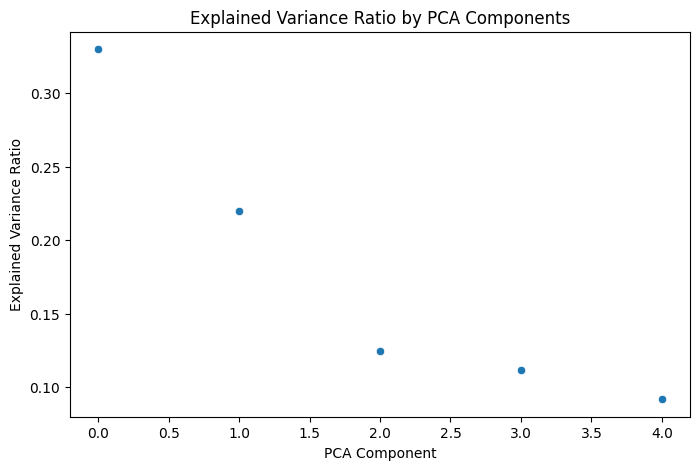

In [81]:
# PCA for dimensionality reduction

pca = PCA(n_components=5)
pca_x = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=[i for i in range(5)], y=pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance Ratio by PCA Components')
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

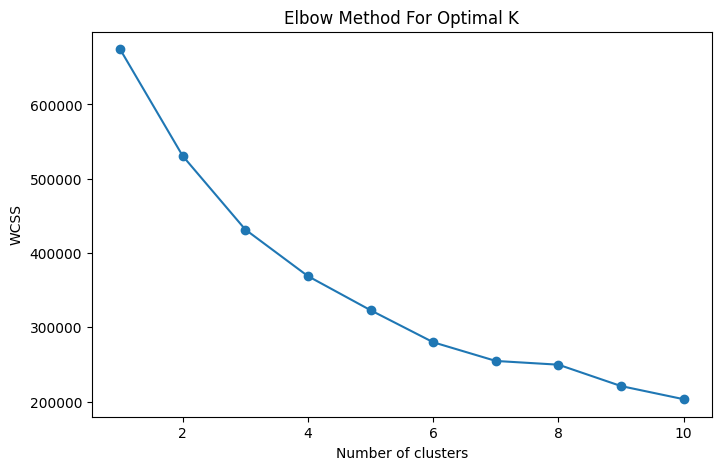

In [82]:
# Elbow method to determine the optimal number of clusters

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(pca_x)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [83]:
# Apply K-Means clustering on the PCA-transformed data

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
customer_data['cluster'] = kmeans.fit_predict(pca_x)

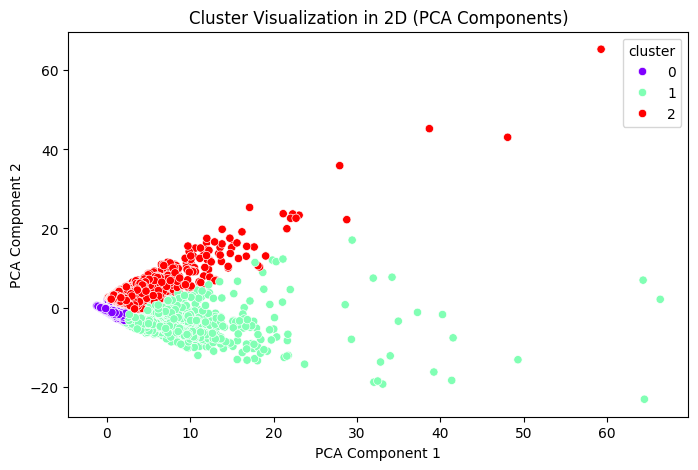

In [84]:
# Visualize the clusters in 2D using PCA components
plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_x[:, 0], y=pca_x[:, 1], hue=customer_data['cluster'], palette='rainbow')
plt.title('Cluster Visualization in 2D (PCA Components)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

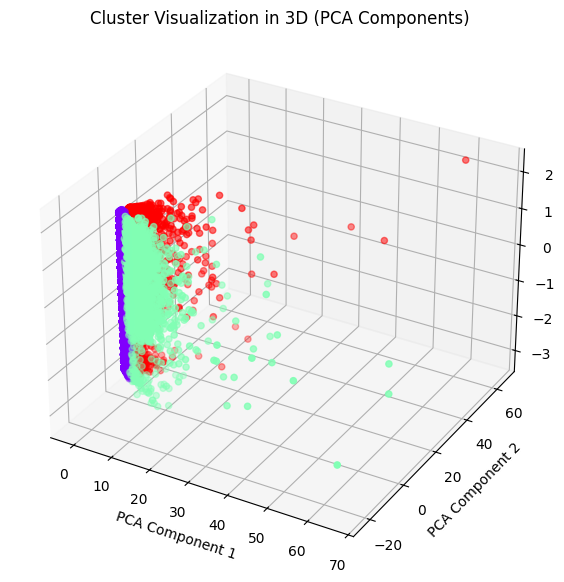

In [85]:
# 3D Visualization of clusters using the first three PCA components

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_x[:, 0], pca_x[:, 1], pca_x[:, 2], c=customer_data['cluster'], cmap='rainbow')
plt.title('Cluster Visualization in 3D (PCA Components)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

In [86]:
# Print clusters informations 

cluster_summary = customer_data.groupby('cluster').agg({
    'freight_value': 'mean',
    'payment_sequential': 'mean',
    'payment_installments': 'mean',
    'num_orders': 'count',
    'clv': 'mean',
    'revenue': 'mean',
    'loyalty': 'mean',
    'order_hour': 'mean',
    'customer_id': 'count'
    
}).rename(columns={'customer_id': 'num_customers'}).reset_index()

print(cluster_summary)


   cluster  freight_value  payment_sequential  payment_installments  \
0        0      19.080069            1.000828              2.758991   
1        1      59.905893            1.059701              6.673417   
2        2      17.786331            1.158694              3.033989   

   num_orders          clv      revenue   loyalty  order_hour  num_customers  
0       80910   209.928770   104.964385  0.000000   14.780200          80910  
1        2881  2102.398556  1051.199278  0.149948   14.835127           2881  
2       12187   375.687162   187.843581  1.000000   14.717732          12187  


In [87]:
# Find the number and propotion in each cluster

cluster_high_value_count = customer_data.groupby('cluster')['high_value_cust'].sum().reset_index()
cluster_high_value_count.columns = ['cluster', 'num_high_value_customers']

cluster_total_count = customer_data['cluster'].value_counts().reset_index()
cluster_total_count.columns = ['cluster', 'total_customers']

cluster_summary = cluster_high_value_count.merge(cluster_total_count, on='cluster')

cluster_summary['proportion_high_value'] = cluster_summary['num_high_value_customers'] / cluster_summary['total_customers']

print(cluster_summary)


   cluster  num_high_value_customers  total_customers  proportion_high_value
0        0                     18514            80910               0.228822
1        1                      2872             2881               0.996876
2        2                      5794            12187               0.475425


#### Additional analysis of Cluster 1 ####

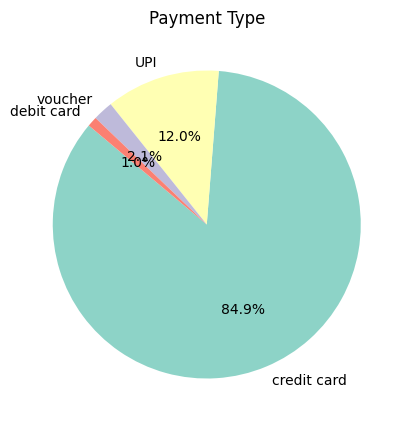

The most preferred payment type in Cluster 1 is: credit card


In [88]:
# Payment type distribution in Cluster 1

cluster_1_customers = customer_data[customer_data['cluster'] == 1]
payment_type_counts = cluster_1_customers['payment_type'].value_counts()


plt.figure(figsize=(8, 5))
plt.pie(payment_type_counts, labels=payment_type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
plt.title('Payment Type')
plt.show()

most_preferred_payment_type = payment_type_counts.idxmax()
print(f"The most preferred payment type in Cluster 1 is: {most_preferred_payment_type}")


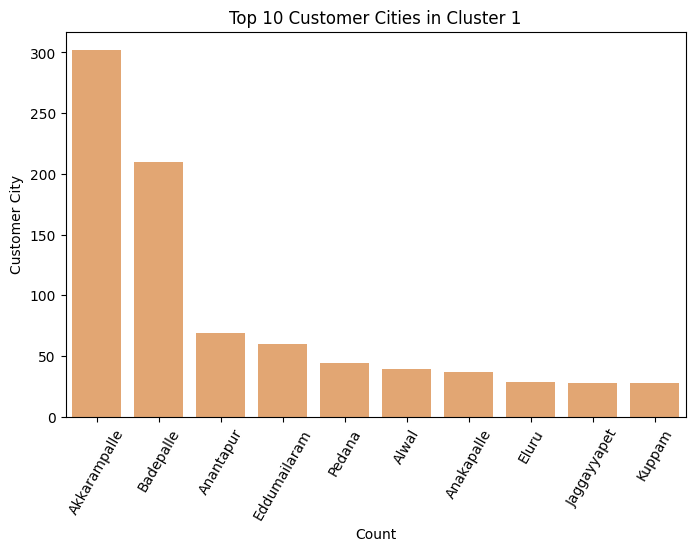

The most common customer city in Cluster 1 is: Akkarampalle


In [89]:
# Plot the distribution of customer cities in Cluster 1
plt.figure(figsize=(8, 5))
sns.countplot(data=cluster_1_customers, x='customer_city', order=cluster_1_customers['customer_city'].value_counts().index[:10], color='sandybrown')
plt.title('Top 10 Customer Cities in Cluster 1')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('Customer City')
plt.show()

most_common_city = cluster_1_customers['customer_city'].value_counts().idxmax()
print(f"The most common customer city in Cluster 1 is: {most_common_city}")


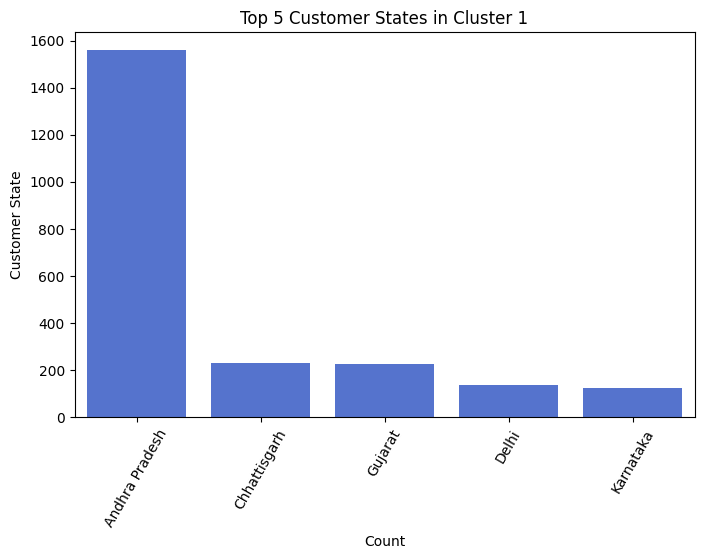

The most common customer state in Cluster 1 is: Andhra Pradesh


In [90]:
# Plot the distribution of customer states in Cluster 1
plt.figure(figsize=(8, 5))
sns.countplot(data=cluster_1_customers, x='customer_state', order=cluster_1_customers['customer_state'].value_counts().index[:5], color='royalblue')
plt.title('Top 5 Customer States in Cluster 1')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('Customer State')
plt.show()

most_common_city = cluster_1_customers['customer_state'].value_counts().idxmax()
print(f"The most common customer state in Cluster 1 is: {most_common_city}")

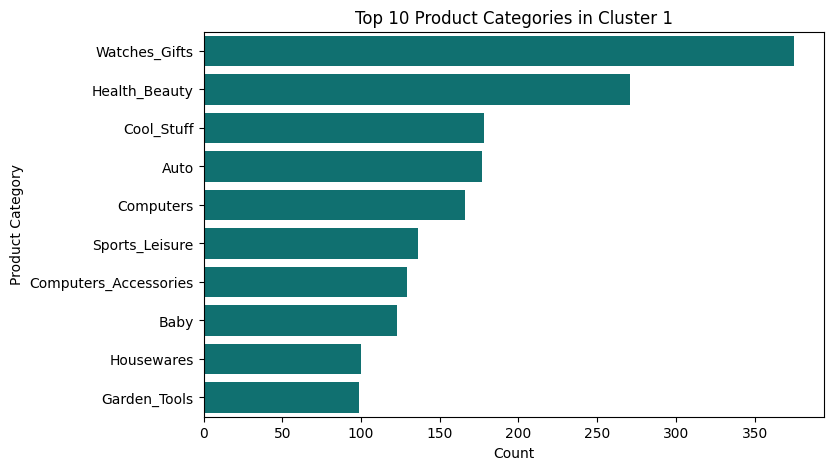

The most popular product category in Cluster 1 is: Watches_Gifts


In [91]:
# Plot the distribution of product categories in Cluster 1
plt.figure(figsize=(8, 5))
sns.countplot(data=cluster_1_customers, y='product_category_name', order=cluster_1_customers['product_category_name'].value_counts().index[:10], color='teal')
plt.title('Top 10 Product Categories in Cluster 1')
plt.xlabel('Count')
plt.ylabel('Product Category')
plt.show()

most_popular_category = cluster_1_customers['product_category_name'].value_counts().idxmax()
print(f"The most popular product category in Cluster 1 is: {most_popular_category}")


#### Delivery Recomendation System ####

#### Delayed Orders Analysis ####

#### The percentage of orders delivered on time is 93.5%. #####
#### this is a solid achievement, our goal is to reach 97% #####

#### 1.	Which customer regions and seller regions experience the most delays? #####

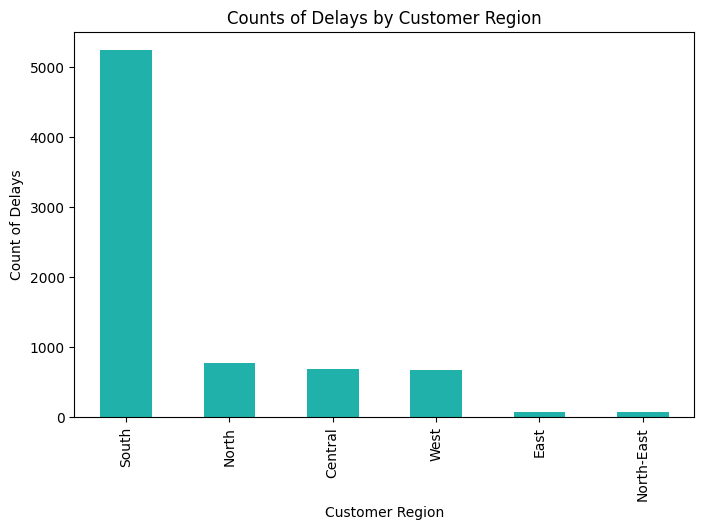

customer_region
South         5244
North          766
Central        690
West           665
East            77
North-East      65
Name: order_id, dtype: int64


In [92]:
# Customer Regions 

delayed_orders = data[data['delay'] == 1]

cust_region_delays = delayed_orders.groupby('customer_region')['order_id'].size()
cust_region_delays = cust_region_delays.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
cust_region_delays.plot(kind='bar', color='lightseagreen')
plt.title('Counts of Delays by Customer Region')
plt.xlabel('Customer Region')
plt.ylabel('Count of Delays')
plt.xticks(rotation=90)
plt.show()

print(cust_region_delays)

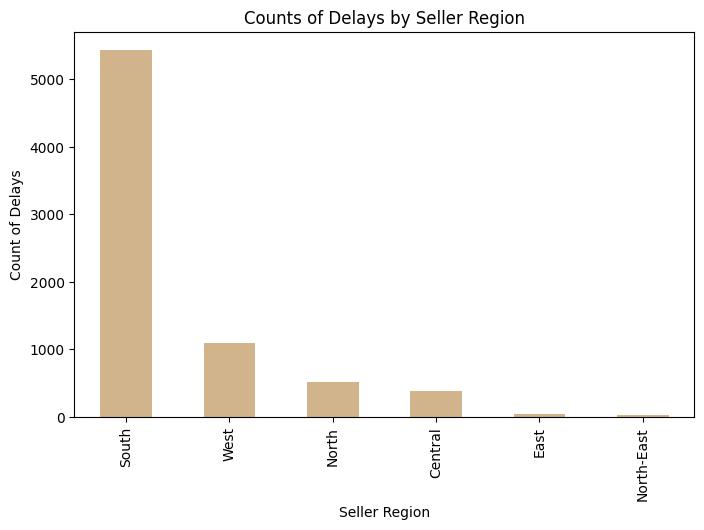

seller_region
South         5432
West          1097
North          516
Central        389
East            45
North-East      28
Name: order_id, dtype: int64


In [93]:
# Seller Region

delayed_orders = data[data['delay'] == 1]

seller_region_delays = delayed_orders.groupby('seller_region')['order_id'].size()
seller_region_delays = seller_region_delays.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
seller_region_delays.plot(kind='bar', color='tan')
plt.title('Counts of Delays by Seller Region')
plt.xlabel('Seller Region')
plt.ylabel('Count of Delays')
plt.xticks(rotation=90)
plt.show()

print(seller_region_delays)

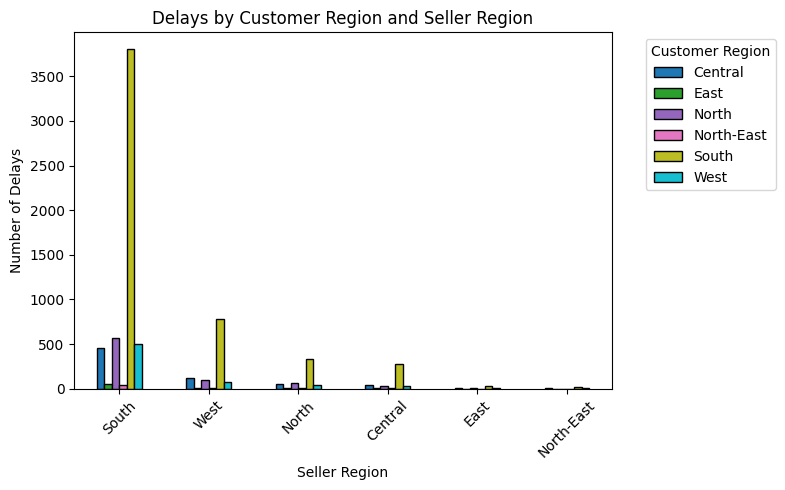

customer_region  Central  East  North  North-East  South  West
seller_region                                                 
South                461    53    570          45   3802   501
West                 123    10     93           9    782    80
North                 57     7     65           5    337    45
Central               37     6     33           4    277    32
East                   6     1      4           1     30     3
North-East             6     0      1           1     16     4


In [94]:
# Combination

delayed_orders = data[data['delay'] == 1]
pivot_table = delayed_orders.pivot_table(index='seller_region', columns='customer_region', values='order_id', aggfunc='size', fill_value=0)

pivot_table = pivot_table.loc[pivot_table.sum(axis=1).sort_values(ascending=False).index]
pivot_table.plot(kind='bar', figsize=(8, 5), colormap='tab10', edgecolor='black')

plt.title('Delays by Customer Region and Seller Region')
plt.xlabel('Seller Region')
plt.ylabel('Number of Delays')
plt.xticks(rotation=45)
plt.legend(title='Customer Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(pivot_table)


#### 2.	Are certain product categories more prone to delays?

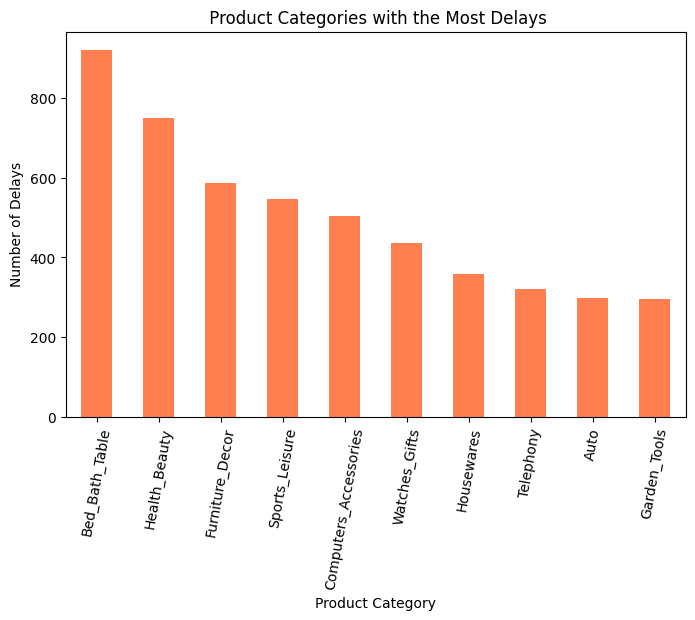

product_category_name
Bed_Bath_Table           921
Health_Beauty            750
Furniture_Decor          587
Sports_Leisure           547
Computers_Accessories    504
Watches_Gifts            437
Housewares               359
Telephony                320
Auto                     298
Garden_Tools             295
Name: count, dtype: int64


In [95]:
category_delays = delayed_orders['product_category_name'].value_counts()

top_10_category_delays = category_delays.head(10)

plt.figure(figsize=(8, 5))
top_10_category_delays.plot(kind='bar', color='coral')
plt.title(' Product Categories with the Most Delays')
plt.xlabel('Product Category')
plt.ylabel('Number of Delays')
plt.xticks(rotation=80)
plt.show()

print(top_10_category_delays)

#### 3. Which months and years exist the more delayed orders? 

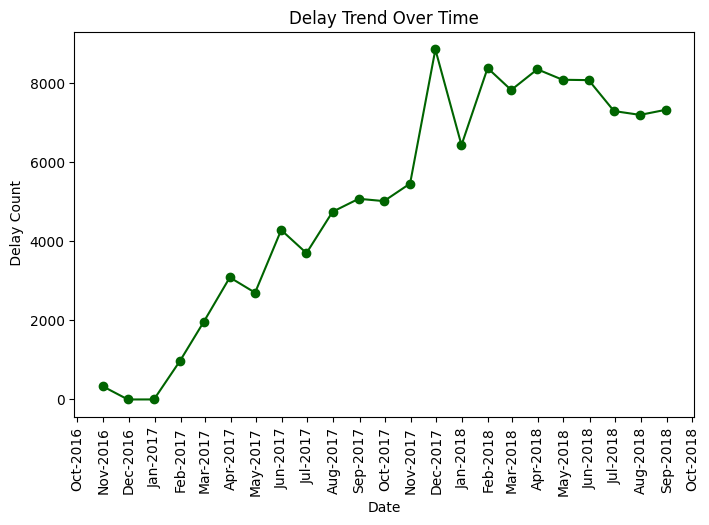

In [96]:
data.set_index('order_purchase_timestamp', inplace=True)
delay_trend = data['delay'].resample('ME').count()

plt.figure(figsize=(8, 5))
plt.plot(delay_trend, marker='o', linestyle='-', color='darkgreen')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90) 
plt.title('Delay Trend Over Time')
plt.xlabel('Date')
plt.ylabel(' Delay Count')
plt.show()

data.reset_index(inplace=True)

columns = ['order_id', 'order_purchase_timestamp'] + [col for col in data.columns if col not in ['order_id', 'order_purchase_timestamp']]
data = data[columns]


In [97]:
print(delay_trend)

order_purchase_timestamp
2016-10-31     335
2016-11-30       0
2016-12-31       1
2017-01-31     979
2017-02-28    1960
2017-03-31    3086
2017-04-30    2700
2017-05-31    4285
2017-06-30    3700
2017-07-31    4746
2017-08-31    5074
2017-09-30    5015
2017-10-31    5459
2017-11-30    8849
2017-12-31    6431
2018-01-31    8379
2018-02-28    7824
2018-03-31    8348
2018-04-30    8083
2018-05-31    8074
2018-06-30    7292
2018-07-31    7195
2018-08-31    7326
Freq: ME, Name: delay, dtype: int64


#### Hypothesis Tests ####

#### 4. Orders from certain customers' region are more likely to be delayed ?

In [98]:
# Null Hypothesis : There is no significant association between customer region and delays

contingency_table_region = pd.crosstab(data['customer_region'], data['delay'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table_region)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant association between customer regions and delays.")
else:
    print("Fail to reject the null hypothesis: No significant association between  customer regions and delays.")

Chi-Square Statistic: 10.119980433328221
P-Value: 0.07190616280988832
Fail to reject the null hypothesis: No significant association between  customer regions and delays.


#### 5. Orders that been sent from certain sellers' regions are more likely to be delayed?

# Null Hypothesis : There is no significant association between seller region and delays

contingency_table_region = pd.crosstab(data['seller_region'], data['delay'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table_region)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant association between seller region and delays.")
else:
    print("Fail to reject the null hypothesis: No significant association between seller region and delays.")


#### 6. Orders in some certain months are more likely to be delayed?

In [99]:
# Null Hypothesis : There is no significant association between months and delays 

contingency_table_month = pd.crosstab(data['month'], data['delay'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table_month)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant association between months and delays.")
else:
    print("Fail to reject the null hypothesis: No significant association between months and delays.")


Chi-Square Statistic: 2179.467022330429
P-Value: 0.0
Reject the null hypothesis: There is a significant association between months and delays.


#### 7. There is an association between product and delays

In [100]:
# Null Hypothesis : There is no significant association between product and delays 

contingency_table_month = pd.crosstab(data['product_category_name'], data['delay'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table_month)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant association between product and delays.")
else:
    print("Fail to reject the null hypothesis: No significant association between product and delays.")

Chi-Square Statistic: 201.50424096547547
P-Value: 1.1481895949036629e-14
Reject the null hypothesis: There is a significant association between product and delays.


#### 8.What factors contribute the most to order delays? Can we predict if an order will be delayed based on the available features?

                       volume  handling_time  days_until_ship  \
volume               1.000000       0.145026        -0.021328   
handling_time        0.145026       1.000000        -0.401727   
days_until_ship     -0.021328      -0.401727         1.000000   
product_weight_g     0.807344       0.146647        -0.012194   
shipping_time        0.031803       0.242247        -0.548733   
total_delivery_days  0.077946       0.406863        -0.146877   
distance            -0.011043       0.019667        -0.000510   
delay_days           0.009799       0.197711        -0.250450   

                     product_weight_g  shipping_time  total_delivery_days  \
volume                       0.807344       0.031803             0.077946   
handling_time                0.146647       0.242247             0.406863   
days_until_ship             -0.012194      -0.548733            -0.146877   
product_weight_g             1.000000       0.032481             0.084946   
shipping_time                

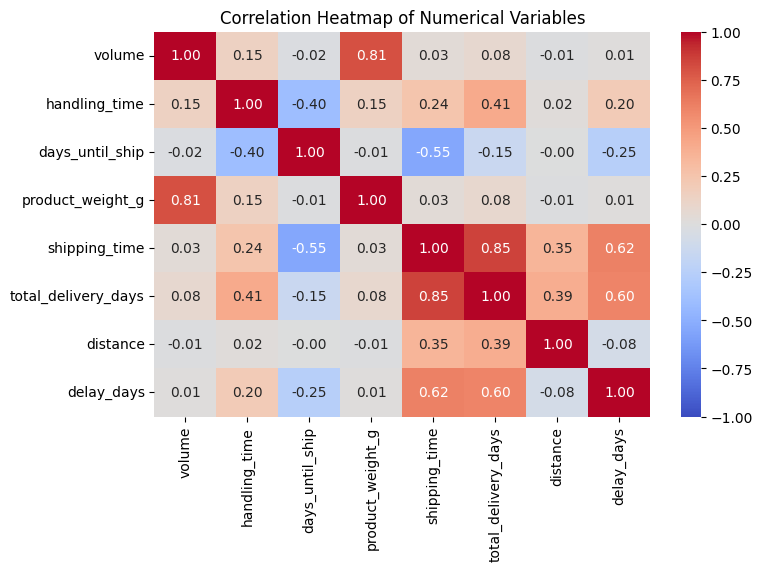

In [101]:
# Heatmap to determine the correlation between numerical variables

numerical_features = ['volume', 'handling_time', 'days_until_ship', 'product_weight_g', 
                      'shipping_time', 'total_delivery_days', 'distance', 'delay_days']

numerical_data = data[numerical_features]

correlation_matrix = numerical_data.corr()

print(correlation_matrix)

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

In [102]:
# Multicolinearity

X = data[['volume', 'loyalty',  'handling_time', 'days_until_ship',
          'product_weight_g', 'shipping_time', 'distance']]
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

            Feature       VIF
0            volume  4.027039
1           loyalty  1.263743
2     handling_time  1.573836
3   days_until_ship  1.622126
4  product_weight_g  3.801630
5     shipping_time  2.050898
6          distance  2.191708


In [103]:
customer_state_counts

customer_state
Andhra Pradesh       58456
Gujarat               7203
Chhattisgarh          6164
Karnataka             3737
Delhi                 3224
Madhya Pradesh        2773
Haryana               2124
Tamil Nadu            2060
Maharashtra           1945
Jammu & Kashmir       1493
Kerala                1486
Arunachal Pradesh     1094
Uttar Pradesh          988
Rajasthan              792
Himachal Pradesh       714
Punjab                 662
Orissa                 612
West Bengal            349
Uttaranchal             93
Goa                      9
Name: count, dtype: int64

In [104]:
seller_state_counts

seller_state
Andhra Pradesh       2018
Gujarat               214
Chhattisgarh          198
Karnataka             101
Delhi                  82
Haryana                65
Jammu & Kashmir        48
Madhya Pradesh         46
Tamil Nadu             41
Maharashtra            34
Arunachal Pradesh      21
Kerala                 18
Rajasthan              17
Himachal Pradesh       15
Punjab                 15
Uttar Pradesh          12
Orissa                  9
West Bengal             8
Uttaranchal             1
Name: count, dtype: int64

In [105]:
# Encoding categorical variables 

ddd = pd.DataFrame(data={"state": customer_state_counts.index, "count": customer_state_counts.values})
ddd = ddd.apply(lambda x: x['state'] if x['count'] > 2000 else 'Other', axis=1)
ddd = ddd.to_list()
data['top_cust_state'] = data.apply(lambda x: x['customer_state'] if x['customer_state'] in ddd else 'Other', axis=1)

top_5_categories = data['product_category_name'].value_counts().nlargest(5).index
data['top_category'] = data['product_category_name'].apply(lambda x: x if x in top_5_categories else 'Other')

data_encoded = pd.get_dummies(data, columns=['top_cust_state', 'top_category'])

In [106]:
data_encoded['delay'].value_counts()

delay
0    107634
1      7507
Name: count, dtype: int64

In [107]:
data_encoded.columns

Index(['order_id', 'order_purchase_timestamp', 'customer_id',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_lat',
       'customer_lng', 'seller_lat', 'seller_lng', 'volume', 'loyalty',
       'order_hour', 'handling_time', 'days_until_ship', 'shipping_time',
       'total_delivery_days', 'delay_days', 'delay', 'distance',
       'response_days

In [108]:
# Building and applying Logistic Regression Model 1

features = [ 'loyalty','distance', 'days_until_ship', 'handling_time'] + [ts for ts in data_encoded.columns if 'top_cust_state' in ts] +  [tc for tc in data_encoded.columns if 'top_category_' in tc]

target = 'delay'

X_init = data_encoded[features]
y_init = data[target]

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X_init, y_init)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=20)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

F1-Score: 0.8163
Accuracy: 0.8397
Precision: 0.9532
Recall: 0.7139
ROC-AUC: 0.9104
Confusion Matrix:
[[20812   754]
 [ 6148 15340]]
Cross-Validation Accuracy Scores: [0.75953454 0.85715613 0.8566916  0.85826772 0.8604743 ]
Mean CV Accuracy: 0.8384 ± 0.0395
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.97      0.86     21566
           1       0.95      0.71      0.82     21488

    accuracy                           0.84     43054
   macro avg       0.86      0.84      0.84     43054
weighted avg       0.86      0.84      0.84     43054

                               Feature  Coefficient
0                              loyalty    -0.005451
1                             distance     0.276055
2                      days_until_ship    -1.256164
3                        handling_time     0.066196
4        top_cust_state_Andhra Pradesh     4.462269
5          top_cust_state_Chhattisgarh     2.490657
6                 top_cust_s

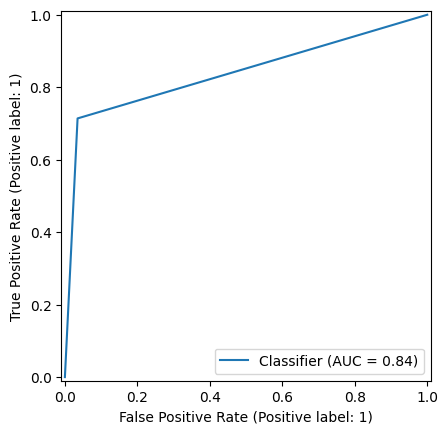

In [109]:
# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cv_scores = cross_val_score(logreg, X_scaled, y, cv=5, scoring='accuracy')
report = classification_report(y_test, y_pred)

print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("Classification Report:\n", report)

# Feature Coefficients
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': logreg.coef_[0]})
print(coef_df)

RocCurveDisplay.from_predictions(y_test, y_pred)

#### Early delivery analysis ####

In [110]:
data_encoded['early_del'] = data_encoded.apply(lambda row: 1 if row['order_delivered_customer_date'] < row['order_estimated_delivery_date'] else 0, axis=1)

Early Delivered Orders: 106131
Not Early Delivered Orders: 9010


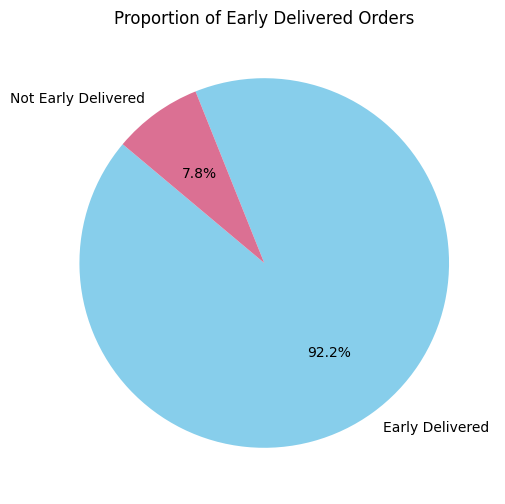

In [111]:
early_del_count = data_encoded['early_del'].sum()
early_del_percentage = (early_del_count / len(data_encoded)) * 100

not_early_del_count = len(data_encoded) - early_del_count
not_early_del_percentage = 100 - early_del_percentage

print(f"Early Delivered Orders: {early_del_count}")
print(f"Not Early Delivered Orders: {not_early_del_count}")

labels = ['Early Delivered', 'Not Early Delivered']
sizes = [early_del_percentage, not_early_del_percentage]
colors = ['skyblue', 'palevioletred']


plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Early Delivered Orders')
plt.show()

Text(0.5, 1.0, 'Number of Early Deliveries by Customer Region')

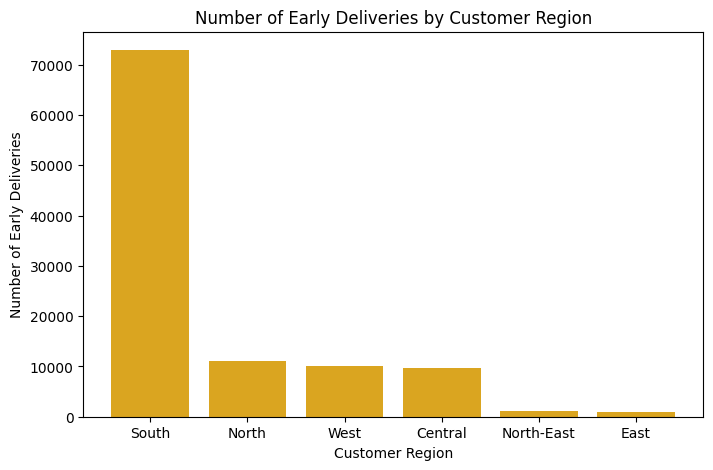

In [112]:
early_del_by_region = data_encoded.groupby('customer_region')['early_del'].sum().reset_index()

early_del_by_region = early_del_by_region.sort_values(by='early_del', ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(early_del_by_region['customer_region'], early_del_by_region['early_del'], color='goldenrod')
plt.xlabel('Customer Region')
plt.ylabel('Number of Early Deliveries')
plt.title('Number of Early Deliveries by Customer Region')


In [113]:
# Building and applying Logistic Regression Model 2

numerical_features = ['distance', 'days_until_ship', 'month', 'loyalty']
target = 'early_del'

X_train, X_test, y_train, y_test = train_test_split(data_encoded[numerical_features], data_encoded[target], test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

clf = Pipeline(steps=[('preprocessor', numeric_transformer),
                      ('classifier', LogisticRegression())])


clf.fit(X_train_smote, y_train_smote)


y_pred = clf.predict(X_test)


F1-Score: 0.7930
Precision: 0.9479
Recall: 0.6816
ROC-AUC: 0.6270
Confusion Matrix:
[[ 1062   793]
 [ 6742 14432]]
Cross-Validation F1 Scores: [0.66349418 0.68511968 0.68169935 0.68275432 0.68000833]
Mean CV F1: 0.6786 ± 0.0077
              precision    recall  f1-score   support

           0       0.14      0.57      0.22      1855
           1       0.95      0.68      0.79     21174

    accuracy                           0.67     23029
   macro avg       0.54      0.63      0.51     23029
weighted avg       0.88      0.67      0.75     23029


Feature Coefficients and Importance:
           Feature  Importance  Absolute_Importance
1  days_until_ship    1.341577             1.341577
3          loyalty    0.457542             0.457542
0         distance   -0.270482             0.270482
2            month    0.267732             0.267732


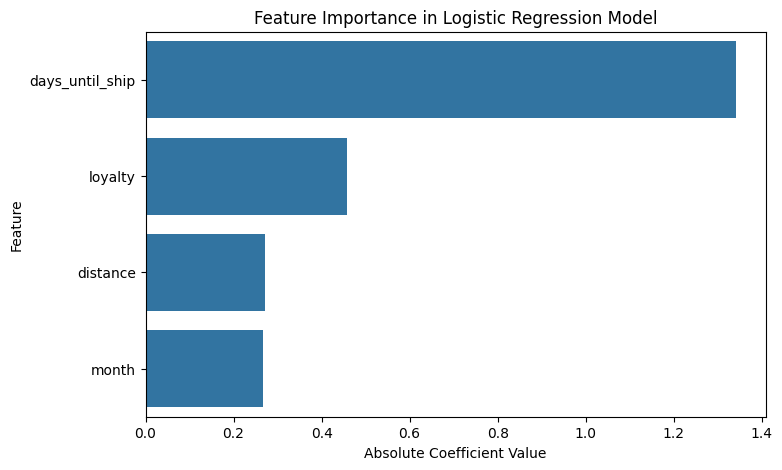

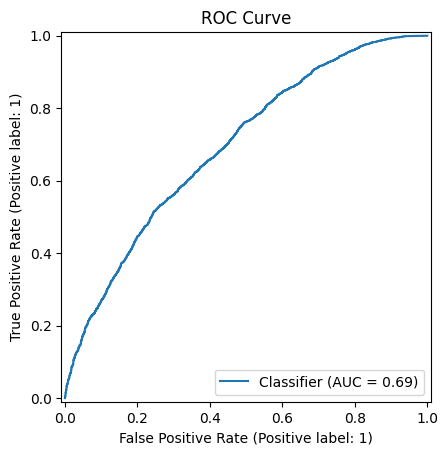

In [114]:
# Evaluate the model

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
cv_scores = cross_val_score(clf, X_train_smote, y_train_smote, cv=5, scoring='f1')

print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(classification_report(y_test, y_pred))

# Extract feature importance
logistic_regression_model = clf.named_steps['classifier']
feature_importance = logistic_regression_model.coef_[0]
feature_importance_df = pd.DataFrame({'Feature': numerical_features, 'Importance': feature_importance})
feature_importance_df['Absolute_Importance'] = np.abs(feature_importance_df['Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Absolute_Importance', ascending=False)

print("\nFeature Coefficients and Importance:")
print(feature_importance_df)

plt.figure(figsize=(8, 5))
sns.barplot(x='Absolute_Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Model')
plt.show()

# Plot the ROC Curve
y_pred_proba = clf.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

plt.title('ROC Curve')
plt.show()